1.IMPORT LIBRARIES

In [9]:
# pip install -r requirements.txt

In [11]:
# Core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import MSELoss
# Data handling
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics & utilities
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Progress & debugging
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import glob
import joblib

device = "mps" if torch.backends.mps.is_available() else "cpu"


2.DATA LOADER AND CREATE SEQUENCES

In [12]:
all_files = sorted(glob.glob("data/monthly_hourly_load_values_*.xlsx"))
df_list = [pd.read_excel(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)
df['DateUTC'] = pd.to_datetime(df['DateUTC'])
df.set_index('DateUTC', inplace=True)

# Training: 2019–2024, Testing: 2025
train_df_full = df[df.index.year < 2025]
test_df = df[df.index.year == 2025]

# Split validation from end of 2024 (10% of training)
val_ratio = 0.1
val_size = int(len(train_df_full) * val_ratio)
val_df = train_df_full.iloc[-val_size:]
train_df = train_df_full.iloc[:-val_size]

def create_sequences(data, seq_len=24, output_len=1):
    X, y = [], []
    for i in range(seq_len, len(data) - output_len + 1):
        X.append(data[i - seq_len:i])
        y.append(data[i:i + output_len].flatten())
    return np.array(X), np.array(y)



def prepare_multi_country_data_per_country_scaler(df, sequence_length=24, prediction_length=1, dataset_name="train/val"):
    """
    For each country, fit a StandardScaler, save it, and normalize values.
    """
    print(f"\n{'='*50}")
    print(f"PREPARING {dataset_name.upper()} WITH PER-COUNTRY SCALER")
    print(f"{'='*50}")

    df_clean = df.dropna(subset=['Value']).copy()
    df_clean = df_clean.sort_values(['CountryCode', 'DateUTC']).reset_index(drop=False)

    sequences = []
    targets = []
    countries = []
    timestamps = []

    for country in df_clean['CountryCode'].unique():
        country_data = df_clean[df_clean['CountryCode'] == country]
        scaler = StandardScaler()
        scaler.fit(country_data[['Value']])
        # Save scaler for later use
        # scaler_filename = f"scaler_{country}.pkl"
        # joblib.dump(scaler, scaler_filename)
        # Normalize values
        country_data['Value_normalized'] = scaler.transform(country_data[['Value']])
        values = country_data['Value_normalized'].values
        dates = country_data['DateUTC'].values
        X_seq, y_seq = create_sequences(values, seq_len=sequence_length, output_len=prediction_length)
        sequences.append(X_seq)
        targets.append(y_seq)
        countries.extend([country] * len(X_seq))
        timestamps.extend(dates[sequence_length:sequence_length+len(X_seq)])

    X = np.concatenate(sequences, axis=0) if sequences else np.array([])
    y = np.concatenate(targets, axis=0) if targets else np.array([])
    countries = np.array(countries)
    timestamps = np.array(timestamps)

    print(f"\nFinal dataset stats:")
    print(f"Total sequences: {len(X):,}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Normalized X range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"Normalized y range: [{y.min():.3f}, {y.max():.3f}]")

    unique_countries, counts = np.unique(countries, return_counts=True)
    print(f"\nCountry distribution in sequences:")
    for country, count in zip(unique_countries, counts):
        print(f"  {country}: {count:,} sequences ({count/len(X)*100:.1f}%)")

    return X, y

X_train, y_train = prepare_multi_country_data_per_country_scaler(
    train_df, sequence_length=24, prediction_length=1
)

X_val, y_val= prepare_multi_country_data_per_country_scaler(
    val_df, sequence_length=24, prediction_length=1
)

X_test, y_test = prepare_multi_country_data_per_country_scaler(
    test_df, sequence_length=24, prediction_length=1,dataset_name="test"
)

print(f"All datasets normalized with the same scaler")
print(f"Train range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Val range:   [{X_val.min():.3f}, {X_val.max():.3f}]")
print(f"Test range:  [{X_test.min():.3f}, {X_test.max():.3f}]")





PREPARING TRAIN/VAL WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 1,649,186
X shape: (1649186, 24)
y shape: (1649186, 1)
Normalized X range: [-6.300, 43.175]
Normalized y range: [-6.300, 43.175]

Country distribution in sequences:
  AL: 24,912 sequences (1.5%)
  AT: 52,584 sequences (3.2%)
  BA: 47,982 sequences (2.9%)
  BE: 52,584 sequences (3.2%)
  BG: 52,584 sequences (3.2%)
  CH: 52,583 sequences (3.2%)
  CY: 27,617 sequences (1.7%)
  CZ: 52,578 sequences (3.2%)
  DE: 52,584 sequences (3.2%)
  DK: 52,583 sequences (3.2%)
  EE: 52,577 sequences (3.2%)
  ES: 52,583 sequences (3.2%)
  FI: 52,584 sequences (3.2%)
  FR: 52,519 sequences (3.2%)
  GB: 36,816 sequences (2.2%)
  GE: 25,806 sequences (1.6%)
  GR: 43,911 sequences (2.7%)
  HR: 43,800 sequences (2.7%)
  HU: 43,798 sequences (2.7%)
  IE: 38,057 sequences (2.3%)
  IT: 43,800 sequences (2.7%)
  LT: 43,798 sequences (2.7%)
  LU: 43,800 sequences (2.7%)
  LV: 43,799 sequences (2.7%)
  MD: 34,307 sequences (2.1%)
 

3.MODEL

LSTM-ATTENTION-CNN

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualBranchTFT(nn.Module):
    def __init__(self, sequence_length, prediction_length, hidden_size=64, num_layers=2, 
                 dropout=0.1, conv_kernels=[3, 7, 15], num_attention_heads=4):
        super().__init__()
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.hidden_size = hidden_size
        
        self.trend_branch = TrendExtractionBranch(
            input_size=1,
            hidden_size=hidden_size,
            conv_kernels=conv_kernels,
            dropout=dropout
        )
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_attention_heads,
            dropout=dropout,
            batch_first=True
        )
        
        self.fusion_type = "gated"  # Options: "concat", "gated", "weighted"
        
        if self.fusion_type == "concat":
            self.fusion_output_size = hidden_size * 2
            self.fusion_projection = nn.Linear(hidden_size * 2, hidden_size)
        elif self.fusion_type == "gated":
            self.fusion_gate = nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Sigmoid()
            )
            self.fusion_output_size = hidden_size
        elif self.fusion_type == "weighted":
            self.fusion_weights = nn.Parameter(torch.ones(2))  # Two branches
            self.fusion_output_size = hidden_size
        
        # Layer normalizations
        self.lstm_norm = nn.LayerNorm(hidden_size)
        self.fusion_norm = nn.LayerNorm(self.fusion_output_size)
        self.output_layer = nn.Sequential(
            nn.Linear(self.fusion_output_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, prediction_length)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, 1)
        batch_size = x.size(0)
        
        trend_features = self.trend_branch(x)  # (batch_size, hidden_size)
        
        # LSTM encoding
        lstm_output, (hidden, cell) = self.encoder_lstm(x)
        lstm_output = self.lstm_norm(lstm_output)
        
        # Self-attention on LSTM outputs
        attended_output, attention_weights = self.attention(
            lstm_output, lstm_output, lstm_output
        )
        
        # Get the final temporal representation (last time step)
        temporal_features = attended_output[:, -1, :]  # (batch_size, hidden_size)
        
        if self.fusion_type == "concat":
            # Simple concatenation with projection
            fused_features = torch.cat([trend_features, temporal_features], dim=-1)
            fused_features = self.fusion_projection(fused_features)
            
        elif self.fusion_type == "gated":
            # Gated fusion - learn which branch to trust more
            combined = torch.cat([trend_features, temporal_features], dim=-1)
            gate = self.fusion_gate(combined)
            fused_features = gate * trend_features + (1 - gate) * temporal_features
            
        elif self.fusion_type == "weighted":
            # Weighted sum of branches
            weights = F.softmax(self.fusion_weights, dim=0)
            fused_features = weights[0] * trend_features + weights[1] * temporal_features
        
        fused_features = self.fusion_norm(fused_features)
        
        output = self.output_layer(fused_features)  # (batch_size, prediction_length)
        
        return output


class TrendExtractionBranch(nn.Module):
    """CNN-based branch for multi-scale trend extraction"""
    
    def __init__(self, input_size, hidden_size, conv_kernels=[3, 7, 15], dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.conv_kernels = conv_kernels
        self.num_kernels = len(conv_kernels)
    
        # Use divisible allocation
        base_channels = hidden_size // self.num_kernels
        remainder = hidden_size % self.num_kernels
        self.output_channels = [base_channels + (1 if i < remainder else 0) 
                              for i in range(self.num_kernels)]
        
        # Parallel convolutional layers with different kernel sizes
        self.conv_layers = nn.ModuleList()
        for i, kernel_size in enumerate(conv_kernels):
            padding = (kernel_size - 1) // 2  # Same padding
            conv_block = nn.Sequential(
                nn.Conv1d(
                    in_channels=input_size,
                    out_channels=self.output_channels[i],
                    kernel_size=kernel_size,
                    padding=padding,
                    padding_mode='replicate'
                ),
                nn.BatchNorm1d(self.output_channels[i]),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.conv_layers.append(conv_block)
        
        # Global pooling to get trend representation
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Feature projection to ensure correct hidden_size
        self.feature_projection = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_size)
        )
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, 1)
        # Rearrange for conv1d: (batch_size, channels, sequence_length)
        x_conv = x.transpose(1, 2)  # (batch_size, 1, sequence_length)
        
        # Apply parallel convolutions
        conv_outputs = []
        for conv_layer in self.conv_layers:
            conv_out = conv_layer(x_conv)  # (batch_size, output_channel_i, seq_len)
            conv_outputs.append(conv_out)
        
        # Concatenate along channel dimension
        combined_conv = torch.cat(conv_outputs, dim=1)  # (batch_size, hidden_size, seq_len)
        
        # Global average pooling to get trend representation
        trend_rep = self.global_pool(combined_conv)  # (batch_size, hidden_size, 1)
        trend_rep = trend_rep.squeeze(-1)  # (batch_size, hidden_size)
        
        # Final projection to ensure correct dimensions
        trend_features = self.feature_projection(trend_rep)  # (batch_size, hidden_size)
        
        return trend_features


sequence_length = 24
prediction_length = 1
hidden_size =128

# Initialize the dual-branch model
model = DualBranchTFT(
    sequence_length=sequence_length,
    prediction_length=prediction_length,
    hidden_size=hidden_size,
    num_layers=2,
    dropout=0.1,
    conv_kernels=[3, 7, 15]  # Multi-scale trend extraction
)
model.load_state_dict(torch.load("model_state_dict.pth"))

<All keys matched successfully>

4.TRAINING PIPELINE

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, learning_rate=1e-4):
    """
    Simple PyTorch training function with tqdm progress bars
    """
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model.to(device)
    
    # Convert data to tensors
    if isinstance(X_train, np.ndarray):
        X_train = torch.FloatTensor(X_train)
    if isinstance(y_train, np.ndarray):
        y_train = torch.FloatTensor(y_train)
    if isinstance(X_val, np.ndarray):
        X_val = torch.FloatTensor(X_val)
    if isinstance(y_val, np.ndarray):
        y_val = torch.FloatTensor(y_val)
    
    # Create DataLoaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    print("Starting training...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        # Create progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            
            # Add channel dimension if needed (batch_size, seq_len) -> (batch_size, seq_len, 1)
            if len(data.shape) == 2:
                data = data.unsqueeze(-1)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.6f}',
                'Avg Loss': f'{train_loss/(batch_idx+1):.6f}'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
        
        with torch.no_grad():
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                if len(data.shape) == 2:
                    data = data.unsqueeze(-1)
                
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                
                # Update validation progress bar
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.6f}',
                    'Avg Loss': f'{val_loss/(len(val_pbar)+1):.6f}'
                })
        
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    print("Training completed!")
    return model,history

In [15]:
# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in model_tft: {count_parameters(model):,}")

Number of trainable parameters in model_tft: 325,157


In [16]:
import matplotlib.pyplot as plt
def plot_partial_predictions(y_true, preds_dict, split_idx=0, group_title="Predictions", window_size=1000, start_idx=0):
    end_idx = start_idx + window_size
    plt.figure(figsize=(15, 5))
    plt.plot(range(start_idx, end_idx), y_true[start_idx:end_idx], label="True", linewidth=2)
    preds_to_plot = np.full_like(y_true[start_idx:end_idx], np.nan)
    preds_window = preds_dict[start_idx:end_idx]
    # Mask predictions before split_idx
    for i in range(window_size):
        global_idx = start_idx + i
        if global_idx >= split_idx and i < len(preds_window):
            preds_to_plot[i] = preds_window[i]
    plt.plot(range(start_idx, end_idx), preds_to_plot, label="Predicted", linewidth=2)
    if split_idx > start_idx and split_idx < end_idx:
        plt.axvline(split_idx, color='r', linestyle='--', label='Test Split')
    plt.title(group_title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
def evaluate_model(y_true, y_pred, scaler=None):
    # Remove any extra dimensions but keep the prediction_length dimension
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    # Store original shapes for debugging
    original_shape_true = y_true.shape
    original_shape_pred = y_pred.shape
    
    print(f"Debug - y_true shape: {original_shape_true}, y_pred shape: {original_shape_pred}")
    
    if scaler:
        # For multi-step forecasting, we need to handle each time step separately
        # or flatten, transform, then reshape back
        if len(y_true.shape) > 1:
            # Multi-step forecasting - flatten, transform, then reshape back
            true_flat = y_true.reshape(-1, 1)
            pred_flat = y_pred.reshape(-1, 1)
            
            y_true = scaler.inverse_transform(true_flat).reshape(y_true.shape)
            y_pred = scaler.inverse_transform(pred_flat).reshape(y_pred.shape)
        else:
            # Single-step forecasting
            y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
            y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Handle MAPE carefully to avoid division by zero
    # Use np.where to avoid division by very small numbers
    with np.errstate(divide='ignore', invalid='ignore'):
        ape = np.abs((y_true - y_pred) / np.where(np.abs(y_true) < 1e-8, 1e-8, y_true))
        mape = np.mean(ape) * 100
    
    print(f"Debug - After inverse - y_true range: [{y_true.min():.2f}, {y_true.max():.2f}]")
    print(f"Debug - After inverse - y_pred range: [{y_pred.min():.2f}, {y_pred.max():.2f}]")
    
    return round(rmse, 2), round(mae, 2), round(mape, 2), y_true, y_pred

def test_model(model, X_test, y_test, batch_size=32, scaler=None):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    if isinstance(X_test, np.ndarray):
        X_test = torch.FloatTensor(X_test)
    if isinstance(y_test, np.ndarray):
        y_test = torch.FloatTensor(y_test)
    
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Testing'):
            data, target = data.to(device), target.to(device)
            if len(data.shape) == 2:
                data = data.unsqueeze(-1)
            
            output = model(data)
            all_preds.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Debug: Check shapes before evaluation
    print(f"Before evaluation - all_targets shape: {all_targets.shape}")
    print(f"Before evaluation - all_preds shape: {all_preds.shape}")
    print(f"Before evaluation - all_targets range: [{all_targets.min():.3f}, {all_targets.max():.3f}]")
    print(f"Before evaluation - all_preds range: [{all_preds.min():.3f}, {all_preds.max():.3f}]")
    
    rmse, mae, mape, y_true_inv, y_pred_inv = evaluate_model(all_targets, all_preds, scaler=scaler)
    
    print(f"Test RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'y_true': y_true_inv,
        'y_pred': y_pred_inv
    }

In [18]:
model,history = train_model(model, X_train, y_train,X_val,y_val, epochs=5)

Using device: mps
Starting training...


Epoch 1/5 [Val]: 100%|██████████| 5714/5714 [00:32<00:00, 174.18it/s, Loss=1.157064, Avg Loss=0.019388]


Epoch 1/5 - Train Loss: 0.025957, Val Loss: 0.019391


Epoch 2/5 [Val]: 100%|██████████| 5714/5714 [00:30<00:00, 188.16it/s, Loss=1.126722, Avg Loss=0.018768]


Epoch 2/5 - Train Loss: 0.025628, Val Loss: 0.018771


Epoch 3/5 [Val]: 100%|██████████| 5714/5714 [00:30<00:00, 186.09it/s, Loss=1.204682, Avg Loss=0.019051]


Epoch 3/5 - Train Loss: 0.025438, Val Loss: 0.019054


Epoch 4/5 [Val]: 100%|██████████| 5714/5714 [00:32<00:00, 177.62it/s, Loss=1.066459, Avg Loss=0.018999]


Epoch 4/5 - Train Loss: 0.025379, Val Loss: 0.019003


Epoch 5/5 [Val]: 100%|██████████| 5714/5714 [00:28<00:00, 203.48it/s, Loss=1.393608, Avg Loss=0.018713]


Epoch 5/5 - Train Loss: 0.025272, Val Loss: 0.018716
Training completed!


In [19]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [64]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class GLU(nn.Module):
    """Gated Linear Unit used as gating non-linearity."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features * 2)
        
    def forward(self, x):
        x_proj = self.fc(x)
        a, b = x_proj.chunk(2, dim=-1)
        return a * torch.sigmoid(b)

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=None, dropout=0.1, context_size=None):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

        self.context_fc = nn.Linear(context_size, hidden_size) if context_size is not None else None
        self.gate = nn.Linear(output_size, output_size)
        self.skip = nn.Linear(input_size, output_size) if input_size != output_size else None
        self.layer_norm = nn.LayerNorm(output_size)

    def forward(self, x, context=None):
        """
        x: (B, T, input_size) or (B, input_size)
        context: (B, context_size) or (B, T, context_size)
        """
        residual = x
        
        # Handle different input dimensions
        if x.dim() == 3:  # (B, T, D)
            B, T, D = x.shape
            x_flat = x.reshape(B * T, D)
            if context is not None and self.context_fc is not None:
                if context.dim() == 2:  # (B, context_size)
                    context = context.unsqueeze(1).expand(B, T, -1).reshape(B * T, -1)
                elif context.dim() == 3:  # (B, T, context_size)
                    context = context.reshape(B * T, -1)
        else:
            x_flat = x
            if context is not None and self.context_fc is not None:
                context = context

        x_fc = self.fc1(x_flat)

        if context is not None and self.context_fc is not None:
            context_proj = self.context_fc(context)
            x_fc = x_fc + context_proj

        x_fc = self.elu(x_fc)
        x_fc = self.fc2(x_fc)
        x_fc = self.dropout(x_fc)

        gated = torch.sigmoid(self.gate(x_fc)) * x_fc

        if x.dim() == 3:
            gated = gated.reshape(B, T, -1)
            residual = residual.reshape(B, T, -1)

        if self.skip is not None:
            residual = self.skip(residual)
            
        output = gated + residual
        return self.layer_norm(output)


class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, context_size=None, dropout=0.1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.context_size = context_size
        
        # GRN for variable selection weights
        self.selection_grn = GatedResidualNetwork(
            input_size, hidden_size, output_size=input_size,
            dropout=dropout, context_size=context_size
        )
        
        # Projection to hidden size
        self.project = nn.Linear(input_size, hidden_size)
        
    def forward(self, x, context=None):
        # x: (B, T, input_size)
        # context: (B, context_size) or None
        
        B, T, D = x.shape
        
        # Get selection weights
        if context is not None and self.context_size is not None:
            # Expand context to match temporal dimension
            if context.dim() == 2:
                context_expanded = context.unsqueeze(1).expand(B, T, -1)
            else:
                context_expanded = context
        else:
            context_expanded = None
            
        # Get selection weights (B, T, input_size)
        selection_weights = self.selection_grn(x, context_expanded)
        selection_weights = F.softmax(selection_weights, dim=-1)
        
        # Apply selection and project
        selected = selection_weights * x
        projected = self.project(selected)  # (B, T, hidden_size)
        
        return projected, selection_weights


class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
        
    def forward(self, q, k, v, attn_mask=None):
        # q: (B, T_q, d_model), k/v: (B, T_k, d_model)
        B, T_q, _ = q.shape
        T_k = k.shape[1]
        
        # Project and reshape for multi-head attention
        q = self.q_proj(q).view(B, T_q, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(k).view(B, T_k, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(v).view(B, T_k, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale  # (B, H, T_q, T_k)
        
        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask == 0, float('-inf'))
            
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to values
        context = torch.matmul(attn_weights, v)  # (B, H, T_q, d_h)
        context = context.transpose(1, 2).contiguous().view(B, T_q, self.d_model)
        
        # Output projection
        output = self.out_proj(context)
        return output, attn_weights

class TemporalFusionDecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.attn = InterpretableMultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.attn_gating = nn.Linear(d_model, d_model)
        self.attn_res_norm = nn.LayerNorm(d_model)
        
        # Position-wise feed-forward
        self.post_grn = GatedResidualNetwork(d_model, d_model, output_size=d_model, dropout=dropout)
        
    def forward(self, x, memory, attn_mask=None):
        # x: (B, T_out, d_model), memory: (B, T_mem, d_model)
        
        # Cross-attention
        attended, attn_scores = self.attn(x, memory, memory, attn_mask=attn_mask)
        
        # Gating + residual + layer norm
        gated = torch.sigmoid(self.attn_gating(attended)) * attended
        x = self.attn_res_norm(x + gated)
        
        # Position-wise GRN
        x = self.post_grn(x)
        
        return x, attn_scores

class TrendExtractionBranch(nn.Module):
    """CNN-based branch for multi-scale trend extraction"""
    def __init__(self, input_size, hidden_size, conv_kernels=[3, 7, 15], dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.conv_kernels = conv_kernels
        self.num_kernels = len(conv_kernels)
        
        # Calculate output channels
        base_channels = hidden_size // self.num_kernels
        remainder = hidden_size % self.num_kernels
        self.output_channels = [base_channels + (1 if i < remainder else 0) 
                              for i in range(self.num_kernels)]
        
        # Parallel convolutional layers
        self.conv_layers = nn.ModuleList()
        for i, kernel_size in enumerate(conv_kernels):
            padding = (kernel_size - 1) // 2
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels=input_size, out_channels=self.output_channels[i],
                         kernel_size=kernel_size, padding=padding, padding_mode='replicate'),
                nn.BatchNorm1d(self.output_channels[i]),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.conv_layers.append(conv_block)
        
        # Global pooling and projection
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.feature_projection = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_size)
        )
        
    def forward(self, x):
        # x: (B, T, input_size)
        x_conv = x.transpose(1, 2)  # (B, input_size, T)
        
        # Apply parallel convolutions
        conv_outputs = []
        for conv_layer in self.conv_layers:
            conv_out = conv_layer(x_conv)  # (B, out_ch_i, T)
            conv_outputs.append(conv_out)
        
        # Concatenate along channel dimension
        combined = torch.cat(conv_outputs, dim=1)  # (B, hidden_size, T)
        
        # Temporal trend map
        temporal_map = combined.transpose(1, 2)  # (B, T, hidden_size)
        
        # Global pooled trend (static representation)
        pooled = self.global_pool(combined).squeeze(-1)  # (B, hidden_size)
        projected = self.feature_projection(pooled)  # (B, hidden_size)
        
        return temporal_map, projected

class TFTWithTrendTraining(nn.Module):
    def __init__(self, sequence_length, prediction_length, input_size=1, hidden_size=128,
                 num_lstm_layers=1, dropout=0.1, conv_kernels=[3, 7, 15], num_attention_heads=4):
        super().__init__()
        # Same initialization as before
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # All the same components...
        self.trend_branch = TrendExtractionBranch(
            input_size=input_size, hidden_size=hidden_size,
            conv_kernels=conv_kernels, dropout=dropout
        )
        
        self.var_selector = VariableSelectionNetwork(
            input_size=input_size, hidden_size=hidden_size,
            context_size=hidden_size, dropout=dropout
        )
        
        self.static_context_enricher = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size)
        )
        
        self.encoder_lstm = nn.LSTM(
            input_size=hidden_size, hidden_size=hidden_size,
            num_layers=num_lstm_layers, batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0
        )
        
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_size, hidden_size=hidden_size,
            num_layers=num_lstm_layers, batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0
        )
        
        self.static_enrichment_grn = GatedResidualNetwork(
            hidden_size, hidden_size, output_size=hidden_size,
            dropout=dropout, context_size=hidden_size
        )
        
        self.temporal_decoder_block = TemporalFusionDecoderBlock(
            d_model=hidden_size, num_heads=num_attention_heads, dropout=dropout
        )
        
        self.post_grn = GatedResidualNetwork(
            hidden_size, hidden_size, output_size=hidden_size, dropout=dropout
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, prediction_length)
        )
        
    def forward(self, x, return_interpretability=False):
        """
        x: (B, sequence_length, input_size)
        return_interpretability: if True, return tuple (output, interpretability_dict)
                                if False, return only output
        """
        B, T, C = x.shape
        assert T == self.sequence_length
        
        # Forward pass (same as before)
        trend_temporal_map, trend_static = self.trend_branch(x)
        projected_inputs, selection_weights = self.var_selector(x, context=trend_static)
        enc_out, (h_n, c_n) = self.encoder_lstm(projected_inputs)
        static_context = self.static_context_enricher(trend_static)
        static_context_expanded = static_context.unsqueeze(1).expand(B, T, self.hidden_size)
        enc_enriched = self.static_enrichment_grn(enc_out, context=static_context_expanded)
        decoder_start = enc_enriched[:, -1:, :]
        decoder_inputs = decoder_start.repeat(1, self.prediction_length, 1)
        dec_out, _ = self.decoder_lstm(decoder_inputs)
        memory = enc_enriched + trend_temporal_map
        fused_dec, attn_scores = self.temporal_decoder_block(dec_out, memory)
        
        if self.prediction_length > 1:
            final_rep = fused_dec.mean(dim=1)
        else:
            final_rep = fused_dec.squeeze(1)
            
        final_rep = self.post_grn(final_rep)
        output = self.output_layer(final_rep)
        
        if return_interpretability:
            return output, {
                "selection_weights": selection_weights,
                "attention_scores": attn_scores,
                "trend_static": trend_static
            }
        else:
            return output

# Use this version for training
model_tft = TFTWithTrendTraining(
    sequence_length=24, 
    prediction_length=1,
    input_size=1, 
    hidden_size=128, 
    num_lstm_layers=2,
    dropout=0.1, 
    conv_kernels=[3, 7, 15], 
    num_attention_heads=4
)

# Count trainable parameters
def count_parameters(model_tft):
    return sum(p.numel() for p in model_tft.parameters() if p.requires_grad)

print(f"Number of trainable parameters in model_tft: {count_parameters(model):,}")
model_tft.load_state_dict(torch.load("model_state_dict_tft.pth"))

Number of trainable parameters in model_tft: 325,157


<All keys matched successfully>

In [18]:
model_tft, tft_history = train_model(model_tft, X_train, y_train, X_val, y_val, epochs=10)

Using device: mps
Starting training...


Epoch 1/10 [Val]: 100%|██████████| 5714/5714 [00:33<00:00, 168.61it/s, Loss=0.252623, Avg Loss=0.021216]


Epoch 1/10 - Train Loss: 0.033837, Val Loss: 0.021220


Epoch 2/10 [Val]: 100%|██████████| 5714/5714 [00:34<00:00, 167.55it/s, Loss=0.177901, Avg Loss=0.020990]


Epoch 2/10 - Train Loss: 0.029933, Val Loss: 0.020994


Epoch 3/10 [Val]: 100%|██████████| 5714/5714 [00:37<00:00, 153.63it/s, Loss=0.181364, Avg Loss=0.019717]


Epoch 3/10 - Train Loss: 0.029110, Val Loss: 0.019721


Epoch 4/10 [Val]: 100%|██████████| 5714/5714 [00:42<00:00, 135.78it/s, Loss=0.183037, Avg Loss=0.020570]


Epoch 4/10 - Train Loss: 0.028657, Val Loss: 0.020574


Epoch 5/10 [Val]: 100%|██████████| 5714/5714 [00:36<00:00, 156.83it/s, Loss=0.115806, Avg Loss=0.019926]


Epoch 5/10 - Train Loss: 0.028328, Val Loss: 0.019930


Epoch 6/10 [Val]: 100%|██████████| 5714/5714 [00:35<00:00, 160.82it/s, Loss=0.112959, Avg Loss=0.019483]


Epoch 6/10 - Train Loss: 0.028029, Val Loss: 0.019486


Epoch 7/10 [Val]: 100%|██████████| 5714/5714 [00:36<00:00, 157.99it/s, Loss=0.172873, Avg Loss=0.020114]


Epoch 7/10 - Train Loss: 0.027843, Val Loss: 0.020118


Epoch 8/10 [Val]: 100%|██████████| 5714/5714 [00:37<00:00, 152.97it/s, Loss=0.102882, Avg Loss=0.019313]


Epoch 8/10 - Train Loss: 0.027679, Val Loss: 0.019316


Epoch 9/10 [Val]: 100%|██████████| 5714/5714 [00:34<00:00, 166.24it/s, Loss=0.104901, Avg Loss=0.019392]


Epoch 9/10 - Train Loss: 0.027487, Val Loss: 0.019395


Epoch 10/10 [Val]: 100%|██████████| 5714/5714 [00:38<00:00, 148.99it/s, Loss=0.081681, Avg Loss=0.018789]

Epoch 10/10 - Train Loss: 0.027356, Val Loss: 0.018793
Training completed!


In [19]:
torch.save(model_tft.state_dict(),"model_state_dict_tft.pth")

In [20]:
def test_model_per_country(model, df, sequence_length=24, prediction_length=1, batch_size=32):
    """
    Test the model for each country using its own saved StandardScaler.
    """
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    countries = df['CountryCode'].unique()
    results_dict = {}

    for country in countries:
        country_df = df[df['CountryCode'] == country].copy()
        scaler_path = f"scaler_{country}.pkl"
        try:
            scaler = joblib.load(scaler_path)
        except FileNotFoundError:
            print(f"Scaler for {country} not found. Skipping.")
            continue

        # Prepare sequences for this country
        X_test, y_test = prepare_multi_country_data_per_country_scaler(
            country_df, sequence_length=sequence_length, prediction_length=prediction_length, dataset_name="test"
        )
        if len(X_test) == 0:
            print(f"Skipping {country}: Not enough data for sequence_length={sequence_length}")
            continue

        # Convert to tensors
        if isinstance(X_test, np.ndarray):
            X_test = torch.FloatTensor(X_test)
        if isinstance(y_test, np.ndarray):
            y_test = torch.FloatTensor(y_test)

        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target in tqdm(test_loader, desc=f'Testing {country}'):
                data, target = data.to(device), target.to(device)
                if len(data.shape) == 2:
                    data = data.unsqueeze(-1)
                output = model(data)
                all_preds.append(output.cpu().numpy())
                all_targets.append(target.cpu().numpy())

        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        # Inverse transform using country scaler
        rmse, mae, mape, y_true_inv, y_pred_inv = evaluate_model(all_targets, all_preds, scaler=scaler)
        print(f"{country} - RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%")

        results_dict[country] = {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'y_true': y_true_inv,
            'y_pred': y_pred_inv
        }

    return results_dict


PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,272
X shape: (4272, 24)
y shape: (4272, 1)
Normalized X range: [-1.645, 2.744]
Normalized y range: [-1.645, 2.744]

Country distribution in sequences:
  AL: 4,272 sequences (100.0%)


Testing AL: 100%|██████████| 134/134 [00:00<00:00, 203.61it/s]


Debug - y_true shape: (4272,), y_pred shape: (4272,)
Debug - After inverse - y_true range: [466.00, 1542.00]
Debug - After inverse - y_pred range: [469.79, 1546.99]
AL - RMSE: 32.1, MAE: 22.3, MAPE: 2.609999895095825%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.986, 2.721]
Normalized y range: [-1.986, 2.721]

Country distribution in sequences:
  AT: 4,320 sequences (100.0%)


Testing AT: 100%|██████████| 135/135 [00:00<00:00, 233.25it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [4201.30, 10401.60]
Debug - After inverse - y_pred range: [4221.71, 10374.28]
AT - RMSE: 127.84, MAE: 99.27, MAPE: 1.4900000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,294
X shape: (4294, 24)
y shape: (4294, 1)
Normalized X range: [-2.295, 3.026]
Normalized y range: [-2.295, 3.026]

Country distribution in sequences:
  BA: 4,294 sequences (100.0%)


Testing BA: 100%|██████████| 135/135 [00:00<00:00, 209.07it/s]


Debug - y_true shape: (4294,), y_pred shape: (4294,)
Debug - After inverse - y_true range: [0.00, 2269.28]
Debug - After inverse - y_pred range: [-279.01, 2261.04]
BA - RMSE: 116.8, MAE: 61.93, MAPE: 26177634.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.205, 2.680]
Normalized y range: [-2.205, 2.680]

Country distribution in sequences:
  BE: 4,320 sequences (100.0%)


Testing BE: 100%|██████████| 135/135 [00:00<00:00, 227.65it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [6142.29, 13031.41]
Debug - After inverse - y_pred range: [6224.36, 13113.87]
BE - RMSE: 175.99, MAE: 133.78, MAPE: 1.4700000286102295%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.738, 2.664]
Normalized y range: [-1.738, 2.664]

Country distribution in sequences:
  BG: 4,320 sequences (100.0%)


Testing BG: 100%|██████████| 135/135 [00:00<00:00, 229.18it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2533.35, 7337.07]
Debug - After inverse - y_pred range: [2522.72, 7281.21]
BG - RMSE: 81.41, MAE: 60.69, MAPE: 1.409999966621399%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-3.817, 7.055]
Normalized y range: [-3.817, 7.055]

Country distribution in sequences:
  CH: 4,320 sequences (100.0%)


Testing CH: 100%|██████████| 135/135 [00:00<00:00, 229.60it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2373.54, 15866.32]
Debug - After inverse - y_pred range: [2889.15, 10017.40]
CH - RMSE: 496.01, MAE: 285.75, MAPE: 4.349999904632568%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,259
X shape: (4259, 24)
y shape: (4259, 1)
Normalized X range: [-1.925, 3.553]
Normalized y range: [-1.925, 3.553]

Country distribution in sequences:
  CY: 4,259 sequences (100.0%)


Testing CY: 100%|██████████| 134/134 [00:00<00:00, 210.95it/s]


Debug - y_true shape: (4259,), y_pred shape: (4259,)
Debug - After inverse - y_true range: [314.61, 1106.49]
Debug - After inverse - y_pred range: [313.59, 1063.08]
CY - RMSE: 20.23, MAE: 13.46, MAPE: 2.2200000286102295%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.269, 2.602]
Normalized y range: [-2.269, 2.602]

Country distribution in sequences:
  CZ: 4,320 sequences (100.0%)


Testing CZ: 100%|██████████| 135/135 [00:00<00:00, 230.89it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [4316.86, 10793.66]
Debug - After inverse - y_pred range: [4093.55, 10802.76]
CZ - RMSE: 123.58, MAE: 97.27, MAPE: 1.3700000047683716%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.150, 2.380]
Normalized y range: [-2.150, 2.380]

Country distribution in sequences:
  DE: 4,320 sequences (100.0%)


Testing DE: 100%|██████████| 135/135 [00:00<00:00, 240.19it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [33628.78, 75361.36]
Debug - After inverse - y_pred range: [33727.93, 74678.61]
DE - RMSE: 764.9, MAE: 600.0, MAPE: 1.149999976158142%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,313
X shape: (4313, 24)
y shape: (4313, 1)
Normalized X range: [-2.703, 2.577]
Normalized y range: [-2.703, 2.577]

Country distribution in sequences:
  DK: 4,313 sequences (100.0%)


Testing DK: 100%|██████████| 135/135 [00:00<00:00, 214.31it/s]


Debug - y_true shape: (4313,), y_pred shape: (4313,)
Debug - After inverse - y_true range: [2454.92, 6251.81]
Debug - After inverse - y_pred range: [2582.50, 6148.48]
DK - RMSE: 116.42, MAE: 84.75, MAPE: 1.9900000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-2.417, 2.915]
Normalized y range: [-2.417, 2.915]

Country distribution in sequences:
  EE: 4,319 sequences (100.0%)


Testing EE: 100%|██████████| 135/135 [00:00<00:00, 211.75it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [482.00, 1437.90]
Debug - After inverse - y_pred range: [495.27, 1424.07]
EE - RMSE: 37.98, MAE: 26.53, MAPE: 3.059999942779541%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-4.681, 2.803]
Normalized y range: [-4.681, 2.803]

Country distribution in sequences:
  ES: 4,320 sequences (100.0%)


Testing ES: 100%|██████████| 135/135 [00:00<00:00, 227.94it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [5599.00, 39696.00]
Debug - After inverse - y_pred range: [12218.15, 38758.75]
ES - RMSE: 755.49, MAE: 390.55, MAPE: 1.590000033378601%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.470, 2.416]
Normalized y range: [-2.470, 2.416]

Country distribution in sequences:
  FI: 4,320 sequences (100.0%)


Testing FI: 100%|██████████| 135/135 [00:00<00:00, 229.08it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [6602.23, 13272.25]
Debug - After inverse - y_pred range: [6617.13, 13179.77]
FI - RMSE: 138.23, MAE: 106.41, MAPE: 1.090000033378601%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-1.960, 3.098]
Normalized y range: [-1.960, 3.098]

Country distribution in sequences:
  FR: 4,319 sequences (100.0%)


Testing FR: 100%|██████████| 135/135 [00:00<00:00, 227.50it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [29309.96, 86645.88]
Debug - After inverse - y_pred range: [29720.79, 84769.08]
FR - RMSE: 944.59, MAE: 687.08, MAPE: 1.3899999856948853%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 2,984
X shape: (2984, 24)
y shape: (2984, 1)
Normalized X range: [-2.057, 3.851]
Normalized y range: [-2.057, 3.851]

Country distribution in sequences:
  GB: 2,984 sequences (100.0%)


Testing GB: 100%|██████████| 94/94 [00:00<00:00, 205.14it/s]


Debug - y_true shape: (2984,), y_pred shape: (2984,)
Debug - After inverse - y_true range: [415.50, 1478.00]
Debug - After inverse - y_pred range: [444.46, 1401.85]
GB - RMSE: 32.82, MAE: 19.81, MAPE: 2.5899999141693115%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,158
X shape: (4158, 24)
y shape: (4158, 1)
Normalized X range: [-2.889, 2.371]
Normalized y range: [-2.889, 2.371]

Country distribution in sequences:
  GE: 4,158 sequences (100.0%)


Testing GE: 100%|██████████| 130/130 [00:00<00:00, 216.75it/s]


Debug - y_true shape: (4158,), y_pred shape: (4158,)
Debug - After inverse - y_true range: [906.09, 2296.83]
Debug - After inverse - y_pred range: [983.75, 2278.30]
GE - RMSE: 40.53, MAE: 26.73, MAPE: 1.659999966621399%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.101, 3.515]
Normalized y range: [-2.101, 3.515]

Country distribution in sequences:
  GR: 4,320 sequences (100.0%)


Testing GR: 100%|██████████| 135/135 [00:00<00:00, 227.67it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [3207.00, 9422.00]
Debug - After inverse - y_pred range: [3221.83, 9111.99]
GR - RMSE: 114.92, MAE: 85.56, MAPE: 1.5499999523162842%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.265, 2.763]
Normalized y range: [-2.265, 2.763]

Country distribution in sequences:
  HR: 4,320 sequences (100.0%)


Testing HR: 100%|██████████| 135/135 [00:00<00:00, 230.11it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [1140.50, 3145.75]
Debug - After inverse - y_pred range: [1205.37, 3128.20]
HR - RMSE: 43.46, MAE: 33.1, MAPE: 1.6399999856948853%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.999, 2.626]
Normalized y range: [-2.999, 2.626]

Country distribution in sequences:
  HU: 4,320 sequences (100.0%)


Testing HU: 100%|██████████| 135/135 [00:00<00:00, 230.92it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2211.19, 7394.76]
Debug - After inverse - y_pred range: [2372.00, 7315.09]
HU - RMSE: 110.18, MAE: 86.03, MAPE: 1.7899999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,301
X shape: (4301, 24)
y shape: (4301, 1)
Normalized X range: [-1.967, 3.398]
Normalized y range: [-1.967, 3.398]

Country distribution in sequences:
  IE: 4,301 sequences (100.0%)


Testing IE: 100%|██████████| 135/135 [00:00<00:00, 216.24it/s]


Debug - y_true shape: (4301,), y_pred shape: (4301,)
Debug - After inverse - y_true range: [2800.23, 5946.52]
Debug - After inverse - y_pred range: [2867.84, 5811.85]
IE - RMSE: 67.38, MAE: 50.79, MAPE: 1.2899999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.020, 2.622]
Normalized y range: [-2.020, 2.622]

Country distribution in sequences:
  IT: 4,320 sequences (100.0%)


Testing IT: 100%|██████████| 135/135 [00:00<00:00, 213.54it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [17486.00, 49148.00]
Debug - After inverse - y_pred range: [17245.83, 48090.49]
IT - RMSE: 520.39, MAE: 399.02, MAPE: 1.2899999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.974, 3.022]
Normalized y range: [-1.974, 3.022]

Country distribution in sequences:
  LT: 4,320 sequences (100.0%)


Testing LT: 100%|██████████| 135/135 [00:00<00:00, 231.02it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [827.56, 2141.05]
Debug - After inverse - y_pred range: [849.86, 2107.57]
LT - RMSE: 43.26, MAE: 30.74, MAPE: 2.309999942779541%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.152, 2.872]
Normalized y range: [-2.152, 2.872]

Country distribution in sequences:
  LU: 4,320 sequences (100.0%)


Testing LU: 100%|██████████| 135/135 [00:00<00:00, 231.08it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [347.27, 849.67]
Debug - After inverse - y_pred range: [349.25, 806.21]
LU - RMSE: 9.38, MAE: 6.65, MAPE: 1.2000000476837158%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.210, 2.480]
Normalized y range: [-2.210, 2.480]

Country distribution in sequences:
  LV: 4,320 sequences (100.0%)


Testing LV: 100%|██████████| 135/135 [00:00<00:00, 230.83it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [477.16, 1195.94]
Debug - After inverse - y_pred range: [481.96, 1177.20]
LV - RMSE: 13.0, MAE: 9.99, MAPE: 1.2400000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,260
X shape: (4260, 24)
y shape: (4260, 1)
Normalized X range: [-3.674, 2.478]
Normalized y range: [-3.674, 2.478]

Country distribution in sequences:
  MD: 4,260 sequences (100.0%)


Testing MD: 100%|██████████| 134/134 [00:00<00:00, 216.06it/s]


Debug - y_true shape: (4260,), y_pred shape: (4260,)
Debug - After inverse - y_true range: [-0.00, 975.00]
Debug - After inverse - y_pred range: [143.43, 959.77]
MD - RMSE: 31.41, MAE: 18.68, MAPE: 2384296.25%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.143, 2.594]
Normalized y range: [-2.143, 2.594]

Country distribution in sequences:
  ME: 4,320 sequences (100.0%)


Testing ME: 100%|██████████| 135/135 [00:00<00:00, 229.24it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [139.07, 569.30]
Debug - After inverse - y_pred range: [145.71, 554.84]
ME - RMSE: 13.71, MAE: 10.18, MAPE: 3.2200000286102295%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 3,312
X shape: (3312, 24)
y shape: (3312, 1)
Normalized X range: [-2.079, 1.915]
Normalized y range: [-2.079, 1.915]

Country distribution in sequences:
  MK: 3,312 sequences (100.0%)


Testing MK: 100%|██████████| 104/104 [00:00<00:00, 227.70it/s]


Debug - y_true shape: (3312,), y_pred shape: (3312,)
Debug - After inverse - y_true range: [-0.00, 1262.39]
Debug - After inverse - y_pred range: [-16.79, 1297.43]
MK - RMSE: 60.69, MAE: 37.9, MAPE: 9176889.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.772, 3.050]
Normalized y range: [-1.772, 3.050]

Country distribution in sequences:
  NL: 4,320 sequences (100.0%)


Testing NL: 100%|██████████| 135/135 [00:00<00:00, 228.72it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [9591.71, 19483.41]
Debug - After inverse - y_pred range: [9554.08, 18957.73]
NL - RMSE: 208.28, MAE: 152.38, MAPE: 1.1399999856948853%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.956, 2.380]
Normalized y range: [-1.956, 2.380]

Country distribution in sequences:
  NO: 4,320 sequences (100.0%)


Testing NO: 100%|██████████| 135/135 [00:00<00:00, 229.92it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [10493.05, 23414.45]
Debug - After inverse - y_pred range: [10652.26, 23120.41]
NO - RMSE: 238.47, MAE: 183.21, MAPE: 1.149999976158142%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.471, 2.194]
Normalized y range: [-2.471, 2.194]

Country distribution in sequences:
  PL: 4,320 sequences (100.0%)


Testing PL: 100%|██████████| 135/135 [00:00<00:00, 230.87it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [10610.42, 24843.21]
Debug - After inverse - y_pred range: [10591.17, 24978.24]
PL - RMSE: 331.72, MAE: 244.48, MAPE: 1.3899999856948853%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-5.140, 2.810]
Normalized y range: [-5.140, 2.810]

Country distribution in sequences:
  PT: 4,320 sequences (100.0%)


Testing PT: 100%|██████████| 135/135 [00:00<00:00, 234.55it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [91.00, 9287.10]
Debug - After inverse - y_pred range: [1605.27, 8986.70]
PT - RMSE: 173.76, MAE: 96.46, MAPE: 5.650000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-3.300, 2.539]
Normalized y range: [-3.300, 2.539]

Country distribution in sequences:
  RO: 4,319 sequences (100.0%)


Testing RO: 100%|██████████| 135/135 [00:00<00:00, 216.91it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [2546.75, 8882.50]
Debug - After inverse - y_pred range: [2947.81, 8868.52]
RO - RMSE: 159.34, MAE: 100.36, MAPE: 1.7200000286102295%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.278, 2.385]
Normalized y range: [-2.278, 2.385]

Country distribution in sequences:
  RS: 4,320 sequences (100.0%)


Testing RS: 100%|██████████| 135/135 [00:00<00:00, 232.59it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2299.00, 5766.00]
Debug - After inverse - y_pred range: [2259.65, 5795.50]
RS - RMSE: 79.45, MAE: 60.4, MAPE: 1.5499999523162842%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.071, 2.473]
Normalized y range: [-2.071, 2.473]

Country distribution in sequences:
  SE: 4,320 sequences (100.0%)


Testing SE: 100%|██████████| 135/135 [00:00<00:00, 231.39it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [9203.00, 23187.00]
Debug - After inverse - y_pred range: [9452.89, 23299.14]
SE - RMSE: 353.45, MAE: 269.48, MAPE: 1.7999999523162842%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,301
X shape: (4301, 24)
y shape: (4301, 1)
Normalized X range: [-3.010, 2.646]
Normalized y range: [-3.010, 2.646]

Country distribution in sequences:
  SI: 4,301 sequences (100.0%)


Testing SI: 100%|██████████| 135/135 [00:00<00:00, 230.46it/s]


Debug - y_true shape: (4301,), y_pred shape: (4301,)
Debug - After inverse - y_true range: [496.43, 2248.73]
Debug - After inverse - y_pred range: [529.02, 2232.32]
SI - RMSE: 52.55, MAE: 38.32, MAPE: 2.799999952316284%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,318
X shape: (4318, 24)
y shape: (4318, 1)
Normalized X range: [-2.258, 2.545]
Normalized y range: [-2.258, 2.545]

Country distribution in sequences:
  SK: 4,318 sequences (100.0%)


Testing SK: 100%|██████████| 135/135 [00:00<00:00, 230.53it/s]


Debug - y_true shape: (4318,), y_pred shape: (4318,)
Debug - After inverse - y_true range: [1952.00, 4157.00]
Debug - After inverse - y_pred range: [1954.15, 4160.22]
SK - RMSE: 60.93, MAE: 44.34, MAPE: 1.4900000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.846, 2.403]
Normalized y range: [-1.846, 2.403]

Country distribution in sequences:
  XK: 4,320 sequences (100.0%)


Testing XK: 100%|██████████| 135/135 [00:00<00:00, 230.10it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [311.43, 1418.44]
Debug - After inverse - y_pred range: [330.21, 1395.45]
XK - RMSE: 26.5, MAE: 19.66, MAPE: 2.7699999809265137%


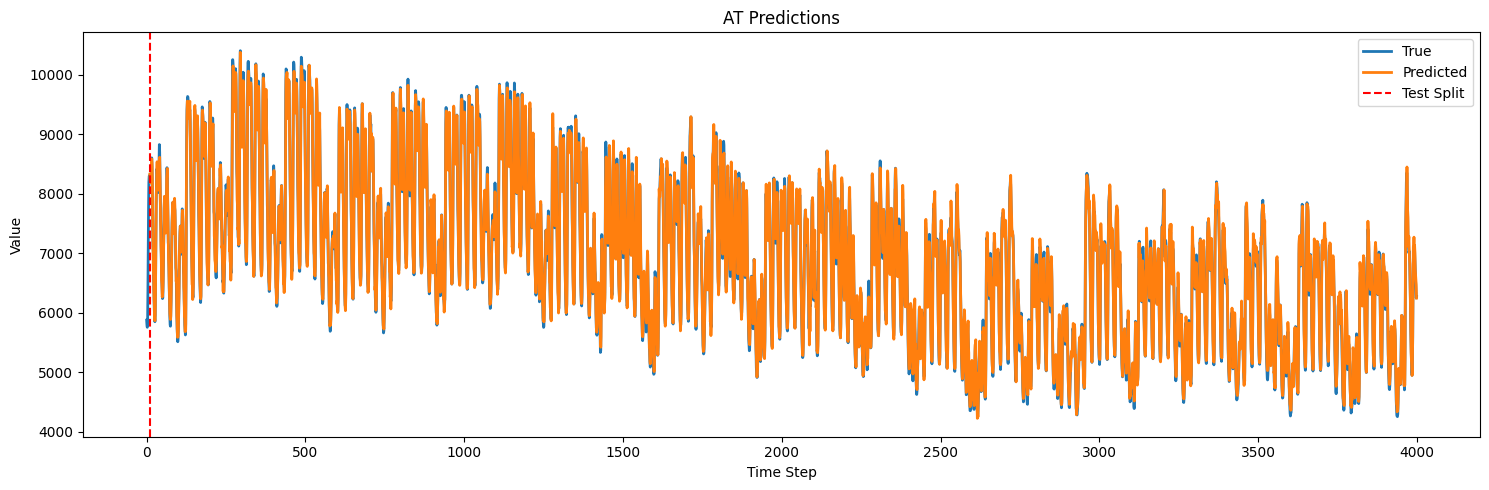

In [ ]:
ressult = test_model_per_country(model=model, df=test_df, sequence_length=24, prediction_length=1)
plot_partial_predictions(
    y_true=ressult['AT']['y_true'],
    preds_dict=ressult['AT']['y_pred'],
    split_idx=50,
    group_title="AT Predictions",
    window_size=700,  # Use the full available length
    start_idx=0
)

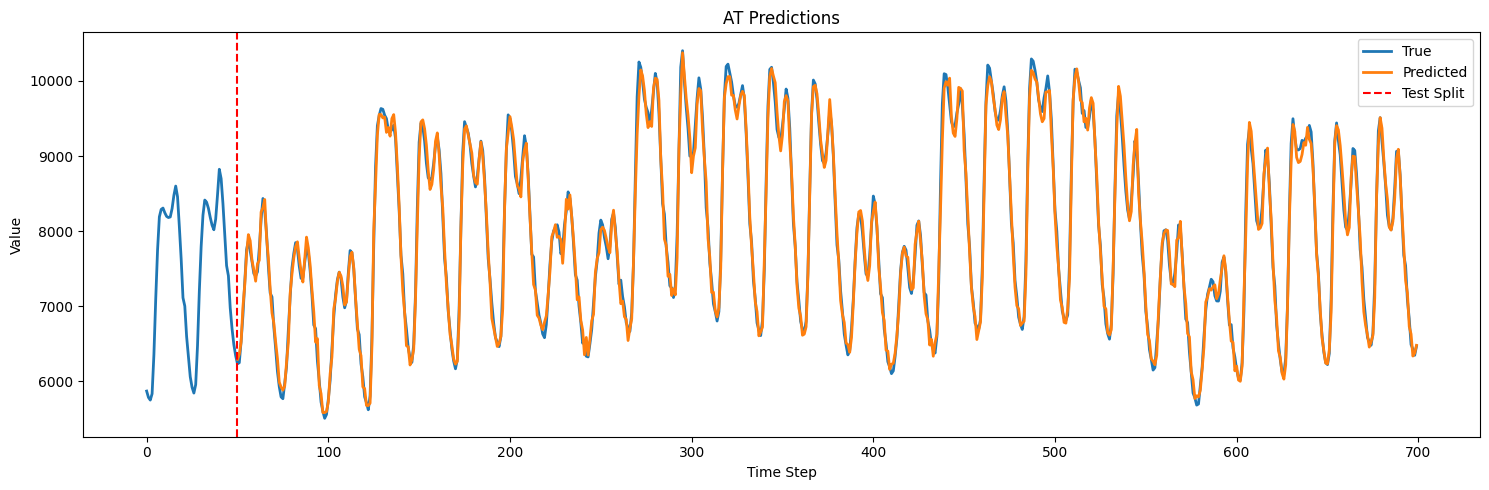

In [22]:
plot_partial_predictions(
    y_true=ressult['AT']['y_true'],
    preds_dict=ressult['AT']['y_pred'],
    split_idx=50,
    group_title="AT Predictions",
    window_size=700,  # Use the full available length
    start_idx=0
)

In [24]:
# Print 5 countries with smallest MAPE from ressult
def print_top5_smallest_mape(results_dict):
    # Create a list of (country, mape) tuples
    mape_list = [(country, results_dict[country]['mape']) for country in results_dict]
    # Sort by MAPE ascending
    mape_list_sorted = sorted(mape_list, key=lambda x: x[1])
    # Print top 5
    print("Top 5 countries with smallest MAPE:")
    for country, mape in mape_list_sorted[:5]:
        print(f"{country}: MAPE = {mape}%")
        print(f"  RMSE = {results_dict[country]['rmse']}, MAE = {results_dict[country]['mae']}")

# Example usage:
print_top5_smallest_mape(ressult)

Top 5 countries with smallest MAPE:
FI: MAPE = 1.059999942779541%
  RMSE = 136.76, MAE = 103.98
NO: MAPE = 1.0700000524520874%
  RMSE = 226.06, MAE = 172.02
NL: MAPE = 1.1100000143051147%
  RMSE = 204.68, MAE = 148.25
DE: MAPE = 1.1200000047683716%
  RMSE = 761.82, MAE = 592.28
LU: MAPE = 1.190000057220459%
  RMSE = 9.17, MAE = 6.62


In [ ]:
df_test_multi = test_df[test_df['CountryCode'].isin(['AT'])].copy()
df_test_multi['multistep']

In [ ]:
# Calculate average metrics excluding countries with MAPE > 10%
def print_average_metrics_exclude_high_mape(results_dict, mape_threshold=10):
    filtered = [v for v in results_dict.values() if v['mape'] <= mape_threshold]
    if not filtered:
        print("No countries with MAPE below threshold.")
        return
    avg_rmse = np.mean([v['rmse'] for v in filtered])
    avg_mae = np.mean([v['mae'] for v in filtered])
    avg_mape = np.mean([v['mape'] for v in filtered])
    print(f"Average metrics for countries with MAPE ≤ {mape_threshold}%:")
    print(f"  RMSE: {avg_rmse:.2f}")
    print(f"  MAE:  {avg_mae:.2f}")
    print(f"  MAPE: {avg_mape:.2f}%")

# Example usage:
print_average_metrics_exclude_high_mape(ressult, mape_threshold=10)

Average metrics for countries with MAPE ≤ 10%:
  RMSE: 187.71
  MAE:  132.34
  MAPE: 1.88%


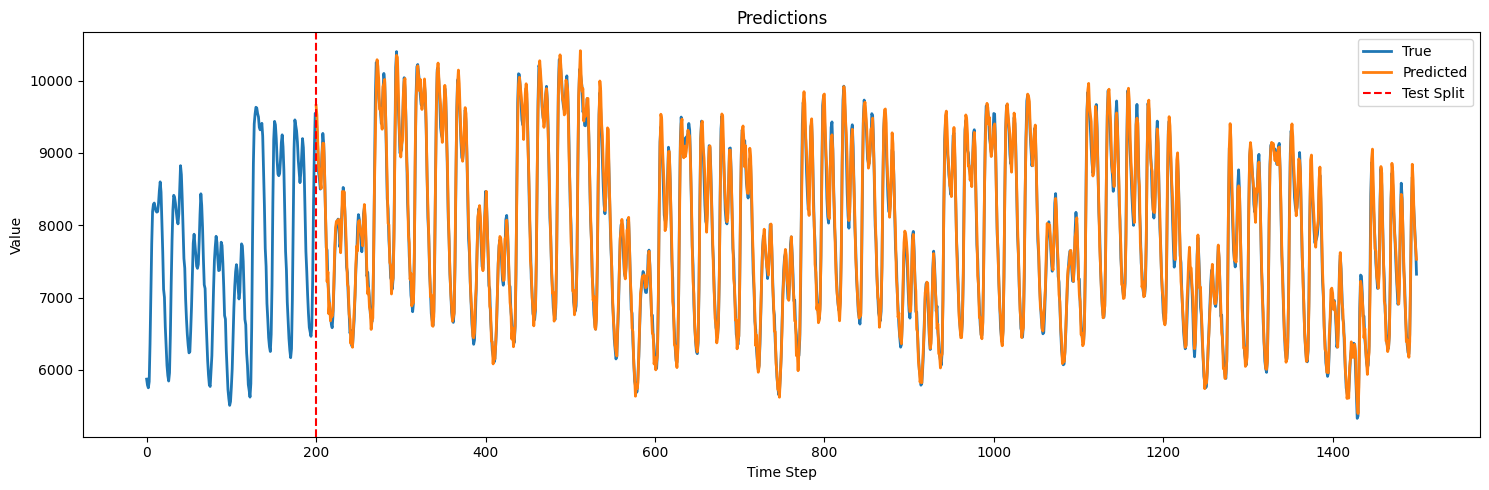

In [42]:
plot_partial_predictions(
    y_true=ressult['AT']['y_true'],
    preds_dict=ressult['AT']['y_pred'],
    split_idx=200,
    group_title="Predictions",
    window_size=1500, 
    start_idx=0
)


PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,272
X shape: (4272, 24)
y shape: (4272, 1)
Normalized X range: [-1.645, 2.744]
Normalized y range: [-1.645, 2.744]

Country distribution in sequences:
  AL: 4,272 sequences (100.0%)


Testing AL: 100%|██████████| 134/134 [00:00<00:00, 147.31it/s]


Debug - y_true shape: (4272,), y_pred shape: (4272,)
Debug - After inverse - y_true range: [466.00, 1542.00]
Debug - After inverse - y_pred range: [471.69, 1574.69]
AL - RMSE: 29.29, MAE: 20.65, MAPE: 2.4000000953674316%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.986, 2.721]
Normalized y range: [-1.986, 2.721]

Country distribution in sequences:
  AT: 4,320 sequences (100.0%)


Testing AT: 100%|██████████| 135/135 [00:00<00:00, 184.40it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [4201.30, 10401.60]
Debug - After inverse - y_pred range: [4253.35, 10425.03]
AT - RMSE: 136.03, MAE: 106.0, MAPE: 1.590000033378601%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,294
X shape: (4294, 24)
y shape: (4294, 1)
Normalized X range: [-2.295, 3.026]
Normalized y range: [-2.295, 3.026]

Country distribution in sequences:
  BA: 4,294 sequences (100.0%)


Testing BA: 100%|██████████| 135/135 [00:00<00:00, 170.47it/s]


Debug - y_true shape: (4294,), y_pred shape: (4294,)
Debug - After inverse - y_true range: [0.00, 2269.28]
Debug - After inverse - y_pred range: [-47.23, 2244.69]
BA - RMSE: 112.26, MAE: 61.04, MAPE: 24607542.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.205, 2.680]
Normalized y range: [-2.205, 2.680]

Country distribution in sequences:
  BE: 4,320 sequences (100.0%)


Testing BE: 100%|██████████| 135/135 [00:00<00:00, 180.82it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [6142.29, 13031.41]
Debug - After inverse - y_pred range: [6286.02, 13187.66]
BE - RMSE: 177.76, MAE: 136.55, MAPE: 1.4900000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.738, 2.664]
Normalized y range: [-1.738, 2.664]

Country distribution in sequences:
  BG: 4,320 sequences (100.0%)


Testing BG: 100%|██████████| 135/135 [00:00<00:00, 186.59it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2533.35, 7337.07]
Debug - After inverse - y_pred range: [2471.35, 7438.51]
BG - RMSE: 82.86, MAE: 61.14, MAPE: 1.399999976158142%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-3.817, 7.055]
Normalized y range: [-3.817, 7.055]

Country distribution in sequences:
  CH: 4,320 sequences (100.0%)


Testing CH: 100%|██████████| 135/135 [00:00<00:00, 168.31it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2373.54, 15866.32]
Debug - After inverse - y_pred range: [3611.71, 11093.86]
CH - RMSE: 425.77, MAE: 279.94, MAPE: 4.349999904632568%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,259
X shape: (4259, 24)
y shape: (4259, 1)
Normalized X range: [-1.925, 3.553]
Normalized y range: [-1.925, 3.553]

Country distribution in sequences:
  CY: 4,259 sequences (100.0%)


Testing CY: 100%|██████████| 134/134 [00:00<00:00, 177.84it/s]


Debug - y_true shape: (4259,), y_pred shape: (4259,)
Debug - After inverse - y_true range: [314.61, 1106.49]
Debug - After inverse - y_pred range: [315.15, 1089.12]
CY - RMSE: 20.15, MAE: 13.16, MAPE: 2.1600000858306885%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.269, 2.602]
Normalized y range: [-2.269, 2.602]

Country distribution in sequences:
  CZ: 4,320 sequences (100.0%)


Testing CZ: 100%|██████████| 135/135 [00:00<00:00, 181.75it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [4316.86, 10793.66]
Debug - After inverse - y_pred range: [4235.18, 10799.73]
CZ - RMSE: 126.79, MAE: 98.99, MAPE: 1.3899999856948853%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.150, 2.380]
Normalized y range: [-2.150, 2.380]

Country distribution in sequences:
  DE: 4,320 sequences (100.0%)


Testing DE: 100%|██████████| 135/135 [00:00<00:00, 179.50it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [33628.78, 75361.36]
Debug - After inverse - y_pred range: [34284.17, 75844.88]
DE - RMSE: 767.94, MAE: 607.28, MAPE: 1.149999976158142%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,313
X shape: (4313, 24)
y shape: (4313, 1)
Normalized X range: [-2.703, 2.577]
Normalized y range: [-2.703, 2.577]

Country distribution in sequences:
  DK: 4,313 sequences (100.0%)


Testing DK: 100%|██████████| 135/135 [00:00<00:00, 173.74it/s]


Debug - y_true shape: (4313,), y_pred shape: (4313,)
Debug - After inverse - y_true range: [2454.92, 6251.81]
Debug - After inverse - y_pred range: [2572.46, 6145.58]
DK - RMSE: 114.02, MAE: 86.0, MAPE: 1.9900000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-2.417, 2.915]
Normalized y range: [-2.417, 2.915]

Country distribution in sequences:
  EE: 4,319 sequences (100.0%)


Testing EE: 100%|██████████| 135/135 [00:00<00:00, 161.55it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [482.00, 1437.90]
Debug - After inverse - y_pred range: [518.08, 1441.30]
EE - RMSE: 37.47, MAE: 26.42, MAPE: 3.0399999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-4.681, 2.803]
Normalized y range: [-4.681, 2.803]

Country distribution in sequences:
  ES: 4,320 sequences (100.0%)


Testing ES: 100%|██████████| 135/135 [00:00<00:00, 172.95it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [5599.00, 39696.00]
Debug - After inverse - y_pred range: [15102.70, 38885.88]
ES - RMSE: 791.03, MAE: 419.04, MAPE: 1.7000000476837158%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.470, 2.416]
Normalized y range: [-2.470, 2.416]

Country distribution in sequences:
  FI: 4,320 sequences (100.0%)


Testing FI: 100%|██████████| 135/135 [00:00<00:00, 167.40it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [6602.23, 13272.25]
Debug - After inverse - y_pred range: [6617.46, 13150.50]
FI - RMSE: 140.56, MAE: 107.8, MAPE: 1.100000023841858%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-1.960, 3.098]
Normalized y range: [-1.960, 3.098]

Country distribution in sequences:
  FR: 4,319 sequences (100.0%)


Testing FR: 100%|██████████| 135/135 [00:00<00:00, 184.70it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [29309.96, 86645.88]
Debug - After inverse - y_pred range: [29535.36, 84473.69]
FR - RMSE: 987.61, MAE: 776.48, MAPE: 1.5399999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 2,984
X shape: (2984, 24)
y shape: (2984, 1)
Normalized X range: [-2.057, 3.851]
Normalized y range: [-2.057, 3.851]

Country distribution in sequences:
  GB: 2,984 sequences (100.0%)


Testing GB: 100%|██████████| 94/94 [00:00<00:00, 179.75it/s]


Debug - y_true shape: (2984,), y_pred shape: (2984,)
Debug - After inverse - y_true range: [415.50, 1478.00]
Debug - After inverse - y_pred range: [432.97, 1388.99]
GB - RMSE: 32.63, MAE: 18.83, MAPE: 2.450000047683716%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,158
X shape: (4158, 24)
y shape: (4158, 1)
Normalized X range: [-2.889, 2.371]
Normalized y range: [-2.889, 2.371]

Country distribution in sequences:
  GE: 4,158 sequences (100.0%)


Testing GE: 100%|██████████| 130/130 [00:00<00:00, 177.50it/s]


Debug - y_true shape: (4158,), y_pred shape: (4158,)
Debug - After inverse - y_true range: [906.09, 2296.83]
Debug - After inverse - y_pred range: [1056.34, 2298.93]
GE - RMSE: 38.43, MAE: 26.54, MAPE: 1.6399999856948853%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.101, 3.515]
Normalized y range: [-2.101, 3.515]

Country distribution in sequences:
  GR: 4,320 sequences (100.0%)


Testing GR: 100%|██████████| 135/135 [00:00<00:00, 172.09it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [3207.00, 9422.00]
Debug - After inverse - y_pred range: [3250.43, 9221.25]
GR - RMSE: 117.21, MAE: 87.26, MAPE: 1.5800000429153442%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.265, 2.763]
Normalized y range: [-2.265, 2.763]

Country distribution in sequences:
  HR: 4,320 sequences (100.0%)


Testing HR: 100%|██████████| 135/135 [00:00<00:00, 182.88it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [1140.50, 3145.75]
Debug - After inverse - y_pred range: [1137.52, 3119.33]
HR - RMSE: 43.91, MAE: 33.08, MAPE: 1.6200000047683716%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.999, 2.626]
Normalized y range: [-2.999, 2.626]

Country distribution in sequences:
  HU: 4,320 sequences (100.0%)


Testing HU: 100%|██████████| 135/135 [00:00<00:00, 190.60it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2211.19, 7394.76]
Debug - After inverse - y_pred range: [2502.28, 7331.55]
HU - RMSE: 110.11, MAE: 84.14, MAPE: 1.7400000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,301
X shape: (4301, 24)
y shape: (4301, 1)
Normalized X range: [-1.967, 3.398]
Normalized y range: [-1.967, 3.398]

Country distribution in sequences:
  IE: 4,301 sequences (100.0%)


Testing IE: 100%|██████████| 135/135 [00:00<00:00, 176.67it/s]


Debug - y_true shape: (4301,), y_pred shape: (4301,)
Debug - After inverse - y_true range: [2800.23, 5946.52]
Debug - After inverse - y_pred range: [2838.90, 5788.72]
IE - RMSE: 65.48, MAE: 49.37, MAPE: 1.25%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.020, 2.622]
Normalized y range: [-2.020, 2.622]

Country distribution in sequences:
  IT: 4,320 sequences (100.0%)


Testing IT: 100%|██████████| 135/135 [00:00<00:00, 179.78it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [17486.00, 49148.00]
Debug - After inverse - y_pred range: [17678.55, 48538.64]
IT - RMSE: 543.62, MAE: 409.42, MAPE: 1.3200000524520874%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.974, 3.022]
Normalized y range: [-1.974, 3.022]

Country distribution in sequences:
  LT: 4,320 sequences (100.0%)


Testing LT: 100%|██████████| 135/135 [00:00<00:00, 182.63it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [827.56, 2141.05]
Debug - After inverse - y_pred range: [853.14, 2127.71]
LT - RMSE: 43.62, MAE: 31.06, MAPE: 2.3299999237060547%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.152, 2.872]
Normalized y range: [-2.152, 2.872]

Country distribution in sequences:
  LU: 4,320 sequences (100.0%)


Testing LU: 100%|██████████| 135/135 [00:00<00:00, 180.16it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [347.27, 849.67]
Debug - After inverse - y_pred range: [353.36, 832.79]
LU - RMSE: 9.54, MAE: 6.92, MAPE: 1.25%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.210, 2.480]
Normalized y range: [-2.210, 2.480]

Country distribution in sequences:
  LV: 4,320 sequences (100.0%)


Testing LV: 100%|██████████| 135/135 [00:00<00:00, 187.57it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [477.16, 1195.94]
Debug - After inverse - y_pred range: [469.68, 1196.89]
LV - RMSE: 14.02, MAE: 10.82, MAPE: 1.3200000524520874%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,260
X shape: (4260, 24)
y shape: (4260, 1)
Normalized X range: [-3.674, 2.478]
Normalized y range: [-3.674, 2.478]

Country distribution in sequences:
  MD: 4,260 sequences (100.0%)


Testing MD: 100%|██████████| 134/134 [00:00<00:00, 182.25it/s]


Debug - y_true shape: (4260,), y_pred shape: (4260,)
Debug - After inverse - y_true range: [-0.00, 975.00]
Debug - After inverse - y_pred range: [165.70, 967.98]
MD - RMSE: 31.58, MAE: 19.02, MAPE: 2346570.5%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.143, 2.594]
Normalized y range: [-2.143, 2.594]

Country distribution in sequences:
  ME: 4,320 sequences (100.0%)


Testing ME: 100%|██████████| 135/135 [00:00<00:00, 188.31it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [139.07, 569.30]
Debug - After inverse - y_pred range: [145.97, 568.97]
ME - RMSE: 13.64, MAE: 9.93, MAPE: 3.119999885559082%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 3,312
X shape: (3312, 24)
y shape: (3312, 1)
Normalized X range: [-2.079, 1.915]
Normalized y range: [-2.079, 1.915]

Country distribution in sequences:
  MK: 3,312 sequences (100.0%)


Testing MK: 100%|██████████| 104/104 [00:00<00:00, 178.51it/s]


Debug - y_true shape: (3312,), y_pred shape: (3312,)
Debug - After inverse - y_true range: [-0.00, 1262.39]
Debug - After inverse - y_pred range: [-47.29, 1261.26]
MK - RMSE: 56.65, MAE: 35.2, MAPE: 7348897.5%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.772, 3.050]
Normalized y range: [-1.772, 3.050]

Country distribution in sequences:
  NL: 4,320 sequences (100.0%)


Testing NL: 100%|██████████| 135/135 [00:00<00:00, 180.83it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [9591.71, 19483.41]
Debug - After inverse - y_pred range: [9609.27, 18966.59]
NL - RMSE: 209.53, MAE: 153.1, MAPE: 1.149999976158142%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.956, 2.380]
Normalized y range: [-1.956, 2.380]

Country distribution in sequences:
  NO: 4,320 sequences (100.0%)


Testing NO: 100%|██████████| 135/135 [00:00<00:00, 179.66it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [10493.05, 23414.45]
Debug - After inverse - y_pred range: [10512.94, 23462.86]
NO - RMSE: 239.67, MAE: 182.25, MAPE: 1.1299999952316284%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.471, 2.194]
Normalized y range: [-2.471, 2.194]

Country distribution in sequences:
  PL: 4,320 sequences (100.0%)


Testing PL: 100%|██████████| 135/135 [00:00<00:00, 188.90it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [10610.42, 24843.21]
Debug - After inverse - y_pred range: [11002.35, 25019.05]
PL - RMSE: 335.37, MAE: 249.09, MAPE: 1.409999966621399%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-5.140, 2.810]
Normalized y range: [-5.140, 2.810]

Country distribution in sequences:
  PT: 4,320 sequences (100.0%)


Testing PT: 100%|██████████| 135/135 [00:00<00:00, 185.52it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [91.00, 9287.10]
Debug - After inverse - y_pred range: [2333.53, 9272.66]
PT - RMSE: 187.24, MAE: 100.24, MAPE: 6.150000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-3.300, 2.539]
Normalized y range: [-3.300, 2.539]

Country distribution in sequences:
  RO: 4,319 sequences (100.0%)


Testing RO: 100%|██████████| 135/135 [00:00<00:00, 182.10it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [2546.75, 8882.50]
Debug - After inverse - y_pred range: [3122.34, 9018.80]
RO - RMSE: 153.7, MAE: 100.71, MAPE: 1.7300000190734863%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.278, 2.385]
Normalized y range: [-2.278, 2.385]

Country distribution in sequences:
  RS: 4,320 sequences (100.0%)


Testing RS: 100%|██████████| 135/135 [00:00<00:00, 187.86it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2299.00, 5766.00]
Debug - After inverse - y_pred range: [2316.05, 5822.92]
RS - RMSE: 81.26, MAE: 60.8, MAPE: 1.5499999523162842%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.071, 2.473]
Normalized y range: [-2.071, 2.473]

Country distribution in sequences:
  SE: 4,320 sequences (100.0%)


Testing SE: 100%|██████████| 135/135 [00:00<00:00, 191.09it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [9203.00, 23187.00]
Debug - After inverse - y_pred range: [9364.00, 23536.63]
SE - RMSE: 355.29, MAE: 272.48, MAPE: 1.809999942779541%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,301
X shape: (4301, 24)
y shape: (4301, 1)
Normalized X range: [-3.010, 2.646]
Normalized y range: [-3.010, 2.646]

Country distribution in sequences:
  SI: 4,301 sequences (100.0%)


Testing SI: 100%|██████████| 135/135 [00:00<00:00, 186.61it/s]


Debug - y_true shape: (4301,), y_pred shape: (4301,)
Debug - After inverse - y_true range: [496.43, 2248.73]
Debug - After inverse - y_pred range: [581.95, 2218.39]
SI - RMSE: 52.23, MAE: 38.3, MAPE: 2.809999942779541%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,318
X shape: (4318, 24)
y shape: (4318, 1)
Normalized X range: [-2.258, 2.545]
Normalized y range: [-2.258, 2.545]

Country distribution in sequences:
  SK: 4,318 sequences (100.0%)


Testing SK: 100%|██████████| 135/135 [00:00<00:00, 183.33it/s]


Debug - y_true shape: (4318,), y_pred shape: (4318,)
Debug - After inverse - y_true range: [1952.00, 4157.00]
Debug - After inverse - y_pred range: [1981.90, 4204.58]
SK - RMSE: 60.0, MAE: 45.78, MAPE: 1.5299999713897705%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.846, 2.403]
Normalized y range: [-1.846, 2.403]

Country distribution in sequences:
  XK: 4,320 sequences (100.0%)


Testing XK: 100%|██████████| 135/135 [00:00<00:00, 181.13it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [311.43, 1418.44]
Debug - After inverse - y_pred range: [302.16, 1408.45]
XK - RMSE: 25.69, MAE: 18.87, MAPE: 2.5899999141693115%


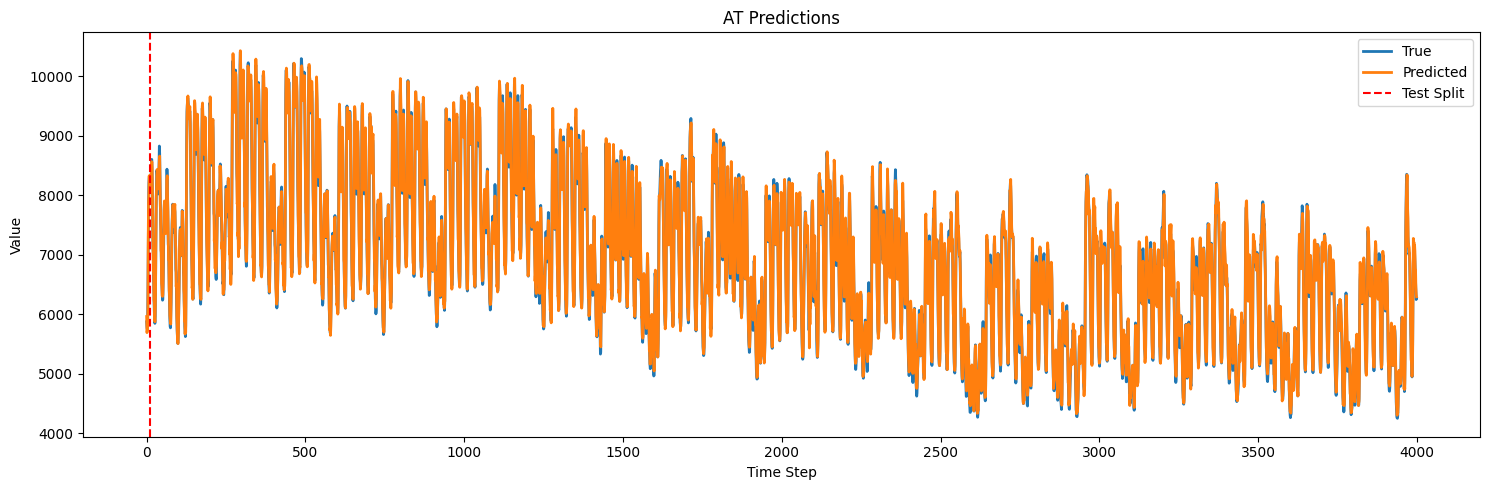

In [20]:
result_tft = test_model_per_country(model=model_tft, df=test_df, sequence_length=24, prediction_length=1)
plot_partial_predictions(
    y_true=result_tft['AT']['y_true'],
    preds_dict=result_tft['AT']['y_pred'],
    split_idx=10,
    group_title="AT Predictions",
    window_size=4000,  # Use the full available length
    start_idx=0
)

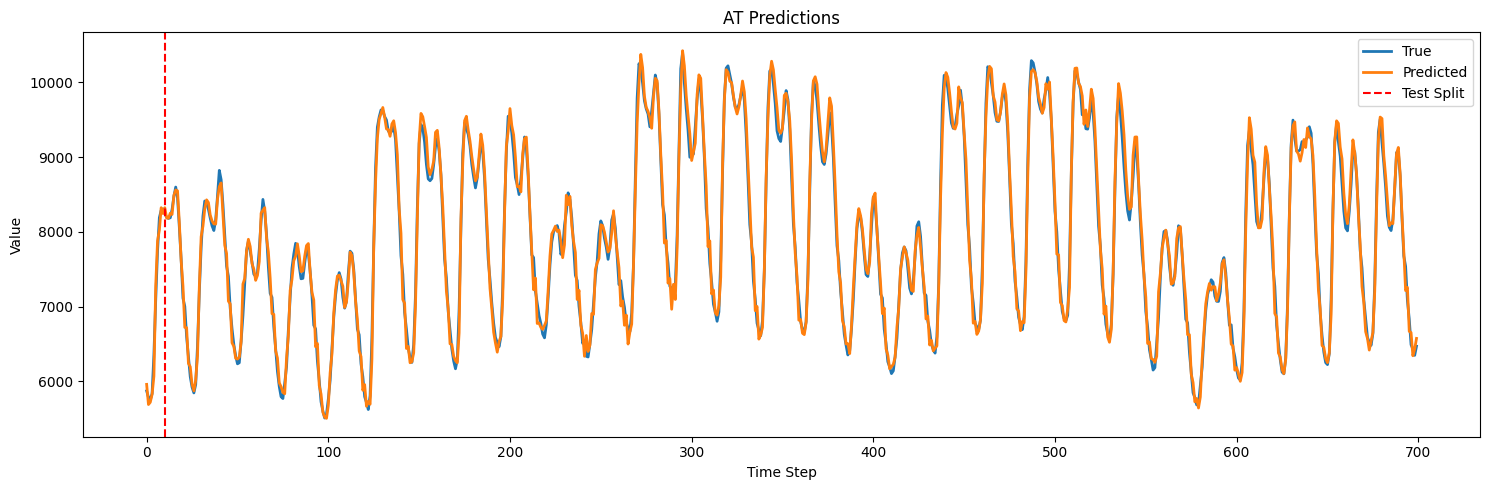

In [21]:
plot_partial_predictions(
    y_true=result_tft['AT']['y_true'],
    preds_dict=result_tft['AT']['y_pred'],
    split_idx=10,
    group_title="AT Predictions",
    window_size=700,  # Use the full available length
    start_idx=0
)

In [26]:
print_average_metrics_exclude_high_mape(result_tft, mape_threshold=10)

Average metrics for countries with MAPE ≤ 10%:
  RMSE: 193.22
  MAE:  139.07
  MAPE: 1.96%


In [9]:
all_files = sorted(glob.glob("data/monthly_hourly_load_values_*.xlsx"))
df_list = [pd.read_excel(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)
df['DateUTC'] = pd.to_datetime(df['DateUTC'])
df.set_index('DateUTC', inplace=True)

# Training: 2019–2024, Testing: 2025
# train_df_full = df[df.index.year < 2025]
test_df = df[df.index.year == 2025]

def create_sequences(data, seq_len=24, output_len=1):
    X, y = [], []
    for i in range(seq_len, len(data) - output_len + 1):
        X.append(data[i - seq_len:i])
        y.append(data[i:i + output_len].flatten())
    return np.array(X), np.array(y)

def prepare_multistep(df, sequence_length=24, prediction_length=1, dataset_name="train/val"):
    """
    For each country, fit a StandardScaler, save it, and normalize values.
    """
    print(f"\n{'='*50}")
    print(f"PREPARING {dataset_name.upper()} WITH PER-COUNTRY SCALER")
    print(f"{'='*50}")

    df_clean = df.dropna(subset=['Value']).copy()
    df_clean = df_clean.sort_values(['CountryCode', 'DateUTC']).reset_index(drop=False)
    df_clean = df_clean[df_clean['CountryCode'] == 'AT']

    sequences = []
    targets = []
    countries = []
    timestamps = []

    for country in df_clean['CountryCode'].unique():
        country_data = df_clean[df_clean['CountryCode'] == country]
        scaler = StandardScaler()
        scaler.fit(country_data[['Value']])
        # Save scaler for later use
        # scaler_filename = f"scaler_{country}.pkl"
        # joblib.dump(scaler, scaler_filename)
        # Normalize values
        country_data['Value_normalized'] = scaler.transform(country_data[['Value']])
        values = country_data['Value_normalized'].values
        dates = country_data['DateUTC'].values
        X_seq, y_seq = create_sequences(values, seq_len=sequence_length, output_len=prediction_length)
        sequences.append(X_seq)
        targets.append(y_seq)
        countries.extend([country] * len(X_seq))
        timestamps.extend(dates[sequence_length:sequence_length+len(X_seq)])

    X = np.concatenate(sequences, axis=0) if sequences else np.array([])
    y = np.concatenate(targets, axis=0) if targets else np.array([])
    countries = np.array(countries)
    timestamps = np.array(timestamps)

    print(f"\nFinal dataset stats:")
    print(f"Total sequences: {len(X):,}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Normalized X range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"Normalized y range: [{y.min():.3f}, {y.max():.3f}]")

    unique_countries, counts = np.unique(countries, return_counts=True)
    print(f"\nCountry distribution in sequences:")
    for country, count in zip(unique_countries, counts):
        print(f"  {country}: {count:,} sequences ({count/len(X)*100:.1f}%)")

    return X, y,countries, timestamps

X_test_AT, y_test_AT, test_countries, test_timestamps = prepare_multistep(
    test_df, sequence_length=24, prediction_length=1, dataset_name="test"
)



PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.986, 2.721]
Normalized y range: [-1.986, 2.721]

Country distribution in sequences:
  AT: 4,320 sequences (100.0%)


In [23]:
def evaluate_model_24h(y_true, y_pred, scaler=None):
    # Remove any extra dimensions but keep the prediction_length dimension
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)

    # Store original shapes for debugging
    original_shape_true = y_true.shape
    original_shape_pred = y_pred.shape

    print(f"Debug - y_true shape: {original_shape_true}, y_pred shape: {original_shape_pred}")

    if scaler:
        # For multi-step forecasting, flatten, inverse, then reshape back
        if len(y_true.shape) > 1:
            true_flat = y_true.reshape(-1, 1)
            pred_flat = y_pred.reshape(-1, 1)
            y_true = scaler.inverse_transform(true_flat).reshape(y_true.shape)
            y_pred = scaler.inverse_transform(pred_flat).reshape(y_pred.shape)
        else:
            y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
            y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Calculate metrics for multi-step: flatten both arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae = mean_absolute_error(y_true_flat, y_pred_flat)

    # Handle MAPE carefully to avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ape = np.abs((y_true_flat - y_pred_flat) / np.where(np.abs(y_true_flat) < 1e-8, 1e-8, y_true_flat))
        mape = np.mean(ape) * 100

    print(f"Debug - After inverse - y_true range: [{y_true_flat.min():.2f}, {y_true_flat.max():.2f}]")
    print(f"Debug - After inverse - y_pred range: [{y_pred_flat.min():.2f}, {y_pred_flat.max():.2f}]")

    return round(rmse, 2), round(mae, 2), round(mape, 2), y_true, y_pred

In [24]:
scaler = StandardScaler()
scaler = joblib.load("scaler_AT.pkl")
df_multi_at = test_df[test_df['CountryCode'].isin(['AT'])].copy()
df_multi_at['Value_normalized'] = scaler.transform(df_multi_at[['Value']])
X_test_AT, y_test_AT = create_sequences(
    df_multi_at['Value_normalized'].values, seq_len=24, output_len=24
)

def test_model_24h(model, X_test_AT, y_test_AT, batch_size=32):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    # Ensure shape: (batch, seq_len, 1)
    X_test_AT_tensor = torch.FloatTensor(X_test_AT).unsqueeze(-1).to(device)
    X_init = X_test_AT_tensor.clone().cpu().numpy()  # shape (batch, 24, 1)

    for t in range(24):  # autoregressive for 24 steps
        inputs = torch.FloatTensor(X_init).to(device)
        output = model(inputs)  # shape (batch, prediction_length)
        all_preds.append(output.cpu().detach().numpy())

        # Slide window: remove first timestep, append output (expand dims if needed)
        if output.dim() == 2:
            output_np = output.cpu().detach().numpy()[:, np.newaxis, :]
        else:
            output_np = output.cpu().detach().numpy()[:, np.newaxis]
        X_init = np.concatenate([X_init[:, 1:, :], output_np], axis=1)

    # Stack predictions to (batch, 24)
    result_dict = np.concatenate(all_preds, axis=1)
    return result_dict



PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,272
X shape: (4272, 24)
y shape: (4272, 1)
Normalized X range: [-1.645, 2.744]
Normalized y range: [-1.645, 2.744]

Country distribution in sequences:
  AL: 4,272 sequences (100.0%)


Testing AL: 100%|██████████| 134/134 [00:00<00:00, 221.77it/s]


Debug - y_true shape: (4272,), y_pred shape: (4272,)
Debug - After inverse - y_true range: [466.00, 1542.00]
Debug - After inverse - y_pred range: [469.79, 1546.99]
AL - RMSE: 32.1, MAE: 22.3, MAPE: 2.609999895095825%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.986, 2.721]
Normalized y range: [-1.986, 2.721]

Country distribution in sequences:
  AT: 4,320 sequences (100.0%)


Testing AT: 100%|██████████| 135/135 [00:00<00:00, 212.01it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [4201.30, 10401.60]
Debug - After inverse - y_pred range: [4221.71, 10374.28]
AT - RMSE: 127.84, MAE: 99.27, MAPE: 1.4900000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,294
X shape: (4294, 24)
y shape: (4294, 1)
Normalized X range: [-2.295, 3.026]
Normalized y range: [-2.295, 3.026]

Country distribution in sequences:
  BA: 4,294 sequences (100.0%)


Testing BA: 100%|██████████| 135/135 [00:00<00:00, 220.90it/s]


Debug - y_true shape: (4294,), y_pred shape: (4294,)
Debug - After inverse - y_true range: [0.00, 2269.28]
Debug - After inverse - y_pred range: [-279.01, 2261.04]
BA - RMSE: 116.8, MAE: 61.93, MAPE: 26177634.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.205, 2.680]
Normalized y range: [-2.205, 2.680]

Country distribution in sequences:
  BE: 4,320 sequences (100.0%)


Testing BE: 100%|██████████| 135/135 [00:00<00:00, 220.26it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [6142.29, 13031.41]
Debug - After inverse - y_pred range: [6224.36, 13113.87]
BE - RMSE: 175.99, MAE: 133.78, MAPE: 1.4700000286102295%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.738, 2.664]
Normalized y range: [-1.738, 2.664]

Country distribution in sequences:
  BG: 4,320 sequences (100.0%)


Testing BG: 100%|██████████| 135/135 [00:00<00:00, 199.57it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2533.35, 7337.07]
Debug - After inverse - y_pred range: [2522.72, 7281.21]
BG - RMSE: 81.41, MAE: 60.69, MAPE: 1.409999966621399%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-3.817, 7.055]
Normalized y range: [-3.817, 7.055]

Country distribution in sequences:
  CH: 4,320 sequences (100.0%)


Testing CH: 100%|██████████| 135/135 [00:00<00:00, 216.66it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2373.54, 15866.32]
Debug - After inverse - y_pred range: [2889.15, 10017.40]
CH - RMSE: 496.01, MAE: 285.75, MAPE: 4.349999904632568%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,259
X shape: (4259, 24)
y shape: (4259, 1)
Normalized X range: [-1.925, 3.553]
Normalized y range: [-1.925, 3.553]

Country distribution in sequences:
  CY: 4,259 sequences (100.0%)


Testing CY: 100%|██████████| 134/134 [00:00<00:00, 218.13it/s]


Debug - y_true shape: (4259,), y_pred shape: (4259,)
Debug - After inverse - y_true range: [314.61, 1106.49]
Debug - After inverse - y_pred range: [313.59, 1063.08]
CY - RMSE: 20.23, MAE: 13.46, MAPE: 2.2200000286102295%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.269, 2.602]
Normalized y range: [-2.269, 2.602]

Country distribution in sequences:
  CZ: 4,320 sequences (100.0%)


Testing CZ: 100%|██████████| 135/135 [00:00<00:00, 219.50it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [4316.86, 10793.66]
Debug - After inverse - y_pred range: [4093.55, 10802.76]
CZ - RMSE: 123.58, MAE: 97.27, MAPE: 1.3700000047683716%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.150, 2.380]
Normalized y range: [-2.150, 2.380]

Country distribution in sequences:
  DE: 4,320 sequences (100.0%)


Testing DE: 100%|██████████| 135/135 [00:00<00:00, 218.71it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [33628.78, 75361.36]
Debug - After inverse - y_pred range: [33727.93, 74678.61]
DE - RMSE: 764.9, MAE: 600.0, MAPE: 1.149999976158142%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,313
X shape: (4313, 24)
y shape: (4313, 1)
Normalized X range: [-2.703, 2.577]
Normalized y range: [-2.703, 2.577]

Country distribution in sequences:
  DK: 4,313 sequences (100.0%)


Testing DK: 100%|██████████| 135/135 [00:00<00:00, 223.29it/s]


Debug - y_true shape: (4313,), y_pred shape: (4313,)
Debug - After inverse - y_true range: [2454.92, 6251.81]
Debug - After inverse - y_pred range: [2582.50, 6148.48]
DK - RMSE: 116.42, MAE: 84.75, MAPE: 1.9900000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-2.417, 2.915]
Normalized y range: [-2.417, 2.915]

Country distribution in sequences:
  EE: 4,319 sequences (100.0%)


Testing EE: 100%|██████████| 135/135 [00:00<00:00, 199.59it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [482.00, 1437.90]
Debug - After inverse - y_pred range: [495.27, 1424.07]
EE - RMSE: 37.98, MAE: 26.53, MAPE: 3.059999942779541%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-4.681, 2.803]
Normalized y range: [-4.681, 2.803]

Country distribution in sequences:
  ES: 4,320 sequences (100.0%)


Testing ES: 100%|██████████| 135/135 [00:00<00:00, 161.22it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [5599.00, 39696.00]
Debug - After inverse - y_pred range: [12218.15, 38758.75]
ES - RMSE: 755.49, MAE: 390.55, MAPE: 1.590000033378601%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.470, 2.416]
Normalized y range: [-2.470, 2.416]

Country distribution in sequences:
  FI: 4,320 sequences (100.0%)


Testing FI: 100%|██████████| 135/135 [00:00<00:00, 228.29it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [6602.23, 13272.25]
Debug - After inverse - y_pred range: [6617.13, 13179.77]
FI - RMSE: 138.23, MAE: 106.41, MAPE: 1.090000033378601%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-1.960, 3.098]
Normalized y range: [-1.960, 3.098]

Country distribution in sequences:
  FR: 4,319 sequences (100.0%)


Testing FR: 100%|██████████| 135/135 [00:00<00:00, 220.80it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [29309.96, 86645.88]
Debug - After inverse - y_pred range: [29720.79, 84769.08]
FR - RMSE: 944.59, MAE: 687.08, MAPE: 1.3899999856948853%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 2,984
X shape: (2984, 24)
y shape: (2984, 1)
Normalized X range: [-2.057, 3.851]
Normalized y range: [-2.057, 3.851]

Country distribution in sequences:
  GB: 2,984 sequences (100.0%)


Testing GB: 100%|██████████| 94/94 [00:00<00:00, 213.18it/s]


Debug - y_true shape: (2984,), y_pred shape: (2984,)
Debug - After inverse - y_true range: [415.50, 1478.00]
Debug - After inverse - y_pred range: [444.46, 1401.85]
GB - RMSE: 32.82, MAE: 19.81, MAPE: 2.5899999141693115%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,158
X shape: (4158, 24)
y shape: (4158, 1)
Normalized X range: [-2.889, 2.371]
Normalized y range: [-2.889, 2.371]

Country distribution in sequences:
  GE: 4,158 sequences (100.0%)


Testing GE: 100%|██████████| 130/130 [00:00<00:00, 209.09it/s]


Debug - y_true shape: (4158,), y_pred shape: (4158,)
Debug - After inverse - y_true range: [906.09, 2296.83]
Debug - After inverse - y_pred range: [983.75, 2278.30]
GE - RMSE: 40.53, MAE: 26.73, MAPE: 1.659999966621399%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.101, 3.515]
Normalized y range: [-2.101, 3.515]

Country distribution in sequences:
  GR: 4,320 sequences (100.0%)


Testing GR: 100%|██████████| 135/135 [00:00<00:00, 225.53it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [3207.00, 9422.00]
Debug - After inverse - y_pred range: [3221.83, 9111.99]
GR - RMSE: 114.92, MAE: 85.56, MAPE: 1.5499999523162842%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.265, 2.763]
Normalized y range: [-2.265, 2.763]

Country distribution in sequences:
  HR: 4,320 sequences (100.0%)


Testing HR: 100%|██████████| 135/135 [00:00<00:00, 225.80it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [1140.50, 3145.75]
Debug - After inverse - y_pred range: [1205.37, 3128.20]
HR - RMSE: 43.46, MAE: 33.1, MAPE: 1.6399999856948853%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.999, 2.626]
Normalized y range: [-2.999, 2.626]

Country distribution in sequences:
  HU: 4,320 sequences (100.0%)


Testing HU: 100%|██████████| 135/135 [00:00<00:00, 228.60it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2211.19, 7394.76]
Debug - After inverse - y_pred range: [2372.00, 7315.09]
HU - RMSE: 110.18, MAE: 86.03, MAPE: 1.7899999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,301
X shape: (4301, 24)
y shape: (4301, 1)
Normalized X range: [-1.967, 3.398]
Normalized y range: [-1.967, 3.398]

Country distribution in sequences:
  IE: 4,301 sequences (100.0%)


Testing IE: 100%|██████████| 135/135 [00:00<00:00, 206.81it/s]


Debug - y_true shape: (4301,), y_pred shape: (4301,)
Debug - After inverse - y_true range: [2800.23, 5946.52]
Debug - After inverse - y_pred range: [2867.84, 5811.85]
IE - RMSE: 67.38, MAE: 50.79, MAPE: 1.2899999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.020, 2.622]
Normalized y range: [-2.020, 2.622]

Country distribution in sequences:
  IT: 4,320 sequences (100.0%)


Testing IT: 100%|██████████| 135/135 [00:00<00:00, 221.24it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [17486.00, 49148.00]
Debug - After inverse - y_pred range: [17245.83, 48090.49]
IT - RMSE: 520.39, MAE: 399.02, MAPE: 1.2899999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.974, 3.022]
Normalized y range: [-1.974, 3.022]

Country distribution in sequences:
  LT: 4,320 sequences (100.0%)


Testing LT: 100%|██████████| 135/135 [00:00<00:00, 229.23it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [827.56, 2141.05]
Debug - After inverse - y_pred range: [849.86, 2107.57]
LT - RMSE: 43.26, MAE: 30.74, MAPE: 2.309999942779541%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.152, 2.872]
Normalized y range: [-2.152, 2.872]

Country distribution in sequences:
  LU: 4,320 sequences (100.0%)


Testing LU: 100%|██████████| 135/135 [00:00<00:00, 213.40it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [347.27, 849.67]
Debug - After inverse - y_pred range: [349.25, 806.21]
LU - RMSE: 9.38, MAE: 6.65, MAPE: 1.2000000476837158%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.210, 2.480]
Normalized y range: [-2.210, 2.480]

Country distribution in sequences:
  LV: 4,320 sequences (100.0%)


Testing LV: 100%|██████████| 135/135 [00:00<00:00, 225.45it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [477.16, 1195.94]
Debug - After inverse - y_pred range: [481.96, 1177.20]
LV - RMSE: 13.0, MAE: 9.99, MAPE: 1.2400000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,260
X shape: (4260, 24)
y shape: (4260, 1)
Normalized X range: [-3.674, 2.478]
Normalized y range: [-3.674, 2.478]

Country distribution in sequences:
  MD: 4,260 sequences (100.0%)


Testing MD: 100%|██████████| 134/134 [00:00<00:00, 258.23it/s]


Debug - y_true shape: (4260,), y_pred shape: (4260,)
Debug - After inverse - y_true range: [-0.00, 975.00]
Debug - After inverse - y_pred range: [143.43, 959.77]
MD - RMSE: 31.41, MAE: 18.68, MAPE: 2384296.25%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.143, 2.594]
Normalized y range: [-2.143, 2.594]

Country distribution in sequences:
  ME: 4,320 sequences (100.0%)


Testing ME: 100%|██████████| 135/135 [00:00<00:00, 220.13it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [139.07, 569.30]
Debug - After inverse - y_pred range: [145.71, 554.84]
ME - RMSE: 13.71, MAE: 10.18, MAPE: 3.2200000286102295%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 3,312
X shape: (3312, 24)
y shape: (3312, 1)
Normalized X range: [-2.079, 1.915]
Normalized y range: [-2.079, 1.915]

Country distribution in sequences:
  MK: 3,312 sequences (100.0%)


Testing MK: 100%|██████████| 104/104 [00:00<00:00, 220.76it/s]


Debug - y_true shape: (3312,), y_pred shape: (3312,)
Debug - After inverse - y_true range: [-0.00, 1262.39]
Debug - After inverse - y_pred range: [-16.79, 1297.43]
MK - RMSE: 60.69, MAE: 37.9, MAPE: 9176889.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.772, 3.050]
Normalized y range: [-1.772, 3.050]

Country distribution in sequences:
  NL: 4,320 sequences (100.0%)


Testing NL: 100%|██████████| 135/135 [00:00<00:00, 208.02it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [9591.71, 19483.41]
Debug - After inverse - y_pred range: [9554.08, 18957.73]
NL - RMSE: 208.28, MAE: 152.38, MAPE: 1.1399999856948853%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.956, 2.380]
Normalized y range: [-1.956, 2.380]

Country distribution in sequences:
  NO: 4,320 sequences (100.0%)


Testing NO: 100%|██████████| 135/135 [00:00<00:00, 228.04it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [10493.05, 23414.45]
Debug - After inverse - y_pred range: [10652.26, 23120.41]
NO - RMSE: 238.47, MAE: 183.21, MAPE: 1.149999976158142%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.471, 2.194]
Normalized y range: [-2.471, 2.194]

Country distribution in sequences:
  PL: 4,320 sequences (100.0%)


Testing PL: 100%|██████████| 135/135 [00:00<00:00, 220.30it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [10610.42, 24843.21]
Debug - After inverse - y_pred range: [10591.17, 24978.24]
PL - RMSE: 331.72, MAE: 244.48, MAPE: 1.3899999856948853%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-5.140, 2.810]
Normalized y range: [-5.140, 2.810]

Country distribution in sequences:
  PT: 4,320 sequences (100.0%)


Testing PT: 100%|██████████| 135/135 [00:00<00:00, 227.38it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [91.00, 9287.10]
Debug - After inverse - y_pred range: [1605.27, 8986.70]
PT - RMSE: 173.76, MAE: 96.46, MAPE: 5.650000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-3.300, 2.539]
Normalized y range: [-3.300, 2.539]

Country distribution in sequences:
  RO: 4,319 sequences (100.0%)


Testing RO: 100%|██████████| 135/135 [00:00<00:00, 212.82it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [2546.75, 8882.50]
Debug - After inverse - y_pred range: [2947.81, 8868.52]
RO - RMSE: 159.34, MAE: 100.36, MAPE: 1.7200000286102295%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.278, 2.385]
Normalized y range: [-2.278, 2.385]

Country distribution in sequences:
  RS: 4,320 sequences (100.0%)


Testing RS: 100%|██████████| 135/135 [00:00<00:00, 228.55it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2299.00, 5766.00]
Debug - After inverse - y_pred range: [2259.65, 5795.50]
RS - RMSE: 79.45, MAE: 60.4, MAPE: 1.5499999523162842%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.071, 2.473]
Normalized y range: [-2.071, 2.473]

Country distribution in sequences:
  SE: 4,320 sequences (100.0%)


Testing SE: 100%|██████████| 135/135 [00:00<00:00, 222.32it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [9203.00, 23187.00]
Debug - After inverse - y_pred range: [9452.89, 23299.14]
SE - RMSE: 353.45, MAE: 269.48, MAPE: 1.7999999523162842%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,301
X shape: (4301, 24)
y shape: (4301, 1)
Normalized X range: [-3.010, 2.646]
Normalized y range: [-3.010, 2.646]

Country distribution in sequences:
  SI: 4,301 sequences (100.0%)


Testing SI: 100%|██████████| 135/135 [00:00<00:00, 226.56it/s]


Debug - y_true shape: (4301,), y_pred shape: (4301,)
Debug - After inverse - y_true range: [496.43, 2248.73]
Debug - After inverse - y_pred range: [529.02, 2232.32]
SI - RMSE: 52.55, MAE: 38.32, MAPE: 2.799999952316284%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,318
X shape: (4318, 24)
y shape: (4318, 1)
Normalized X range: [-2.258, 2.545]
Normalized y range: [-2.258, 2.545]

Country distribution in sequences:
  SK: 4,318 sequences (100.0%)


Testing SK: 100%|██████████| 135/135 [00:00<00:00, 200.21it/s]


Debug - y_true shape: (4318,), y_pred shape: (4318,)
Debug - After inverse - y_true range: [1952.00, 4157.00]
Debug - After inverse - y_pred range: [1954.15, 4160.22]
SK - RMSE: 60.93, MAE: 44.34, MAPE: 1.4900000095367432%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.846, 2.403]
Normalized y range: [-1.846, 2.403]

Country distribution in sequences:
  XK: 4,320 sequences (100.0%)


Testing XK: 100%|██████████| 135/135 [00:00<00:00, 219.84it/s]

Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [311.43, 1418.44]
Debug - After inverse - y_pred range: [330.21, 1395.45]
XK - RMSE: 26.5, MAE: 19.66, MAPE: 2.7699999809265137%


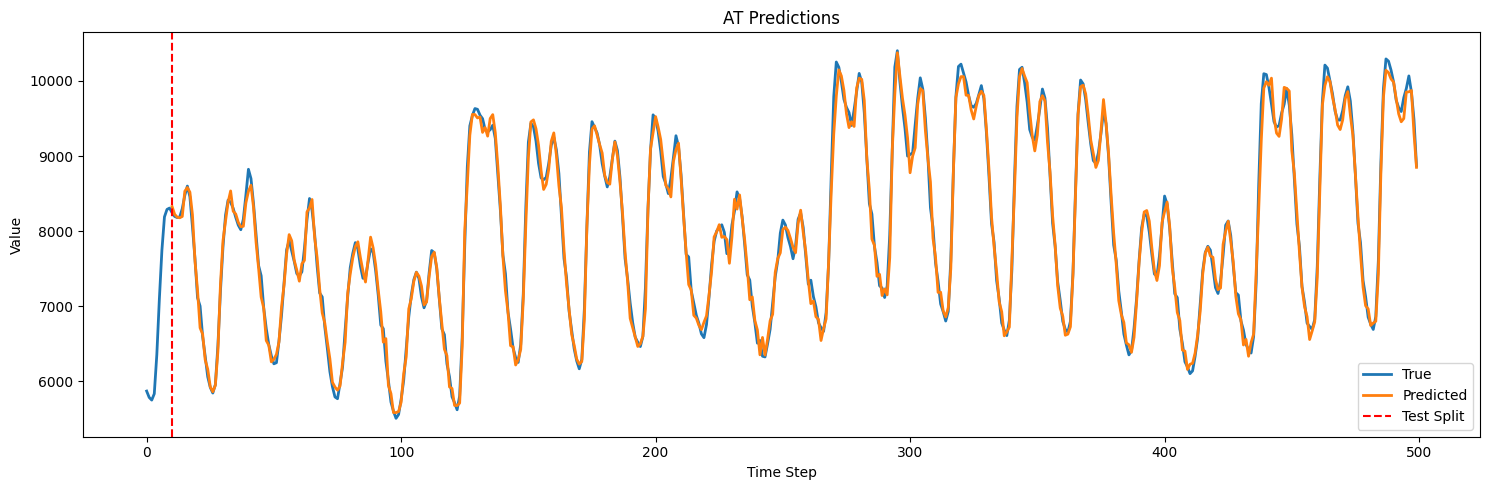

In [26]:
model = DualBranchTFT(
    sequence_length=sequence_length,
    prediction_length=prediction_length,
    hidden_size=hidden_size,
    num_layers=2,
    dropout=0.1,
    conv_kernels=[3, 7, 15]  # Multi-scale trend extraction
)
model_dict = torch.load("model_state_dict.pth")
model.load_state_dict(model_dict)
# result_multi = test_model_24h(model, X_test_AT,y_test_AT,batch_size=32)
result_test = test_model_per_country(model=model, df=test_df, sequence_length=24, prediction_length=1)
plot_partial_predictions(
    y_true=result_test['AT']['y_true'],
    preds_dict=result_test['AT']['y_pred'],
    split_idx=10,
    group_title="AT Predictions",
    window_size=500,  # Use the full available length
    start_idx=0
)

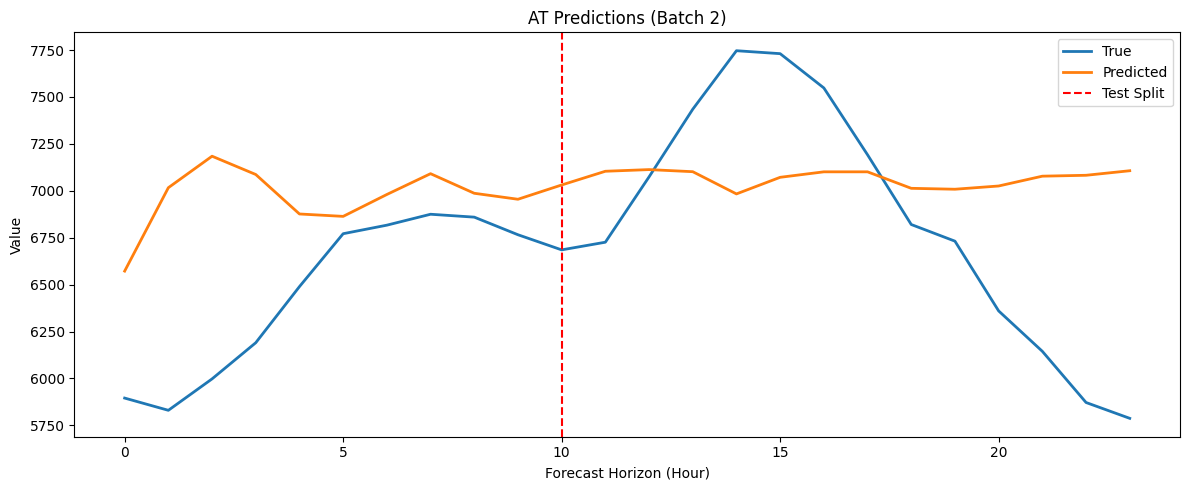

In [58]:
y_preds = scaler.inverse_transform(result_multi.reshape(-1, 1)).reshape(result_multi.shape)
plot_partial_predictions_24h(
    y_true=df_multi_at['Value'].values,
    preds_dict=y_preds,
    split_idx=10,
    group_title="AT Predictions",
    batch_idx=2  # Change to plot other batches
)


PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,272
X shape: (4272, 24)
y shape: (4272, 1)
Normalized X range: [-1.645, 2.744]
Normalized y range: [-1.645, 2.744]

Country distribution in sequences:
  AL: 4,272 sequences (100.0%)


Testing AL: 100%|██████████| 134/134 [00:01<00:00, 68.86it/s] 


Debug - y_true shape: (4272,), y_pred shape: (4272,)
Debug - After inverse - y_true range: [466.00, 1542.00]
Debug - After inverse - y_pred range: [565.11, 1434.06]
AL - RMSE: 59.69, MAE: 48.41, MAPE: 6.730000019073486%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.986, 2.721]
Normalized y range: [-1.986, 2.721]

Country distribution in sequences:
  AT: 4,320 sequences (100.0%)


Testing AT: 100%|██████████| 135/135 [00:00<00:00, 180.98it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [4201.30, 10401.60]
Debug - After inverse - y_pred range: [4803.37, 9630.21]
AT - RMSE: 282.93, MAE: 231.91, MAPE: 3.759999990463257%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,294
X shape: (4294, 24)
y shape: (4294, 1)
Normalized X range: [-2.295, 3.026]
Normalized y range: [-2.295, 3.026]

Country distribution in sequences:
  BA: 4,294 sequences (100.0%)


Testing BA: 100%|██████████| 135/135 [00:01<00:00, 133.85it/s]


Debug - y_true shape: (4294,), y_pred shape: (4294,)
Debug - After inverse - y_true range: [0.00, 2269.28]
Debug - After inverse - y_pred range: [146.17, 1959.37]
BA - RMSE: 140.2, MAE: 96.02, MAPE: 33289832.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.205, 2.680]
Normalized y range: [-2.205, 2.680]

Country distribution in sequences:
  BE: 4,320 sequences (100.0%)


Testing BE: 100%|██████████| 135/135 [00:00<00:00, 191.71it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [6142.29, 13031.41]
Debug - After inverse - y_pred range: [7024.35, 12256.15]
BE - RMSE: 325.55, MAE: 266.84, MAPE: 3.069999933242798%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.738, 2.664]
Normalized y range: [-1.738, 2.664]

Country distribution in sequences:
  BG: 4,320 sequences (100.0%)


Testing BG: 100%|██████████| 135/135 [00:00<00:00, 174.37it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2533.35, 7337.07]
Debug - After inverse - y_pred range: [2978.71, 6845.69]
BG - RMSE: 204.03, MAE: 163.38, MAPE: 4.260000228881836%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-3.817, 7.055]
Normalized y range: [-3.817, 7.055]

Country distribution in sequences:
  CH: 4,320 sequences (100.0%)


Testing CH: 100%|██████████| 135/135 [00:00<00:00, 176.74it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2373.54, 15866.32]
Debug - After inverse - y_pred range: [4385.74, 9841.59]
CH - RMSE: 504.89, MAE: 347.44, MAPE: 5.610000133514404%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,259
X shape: (4259, 24)
y shape: (4259, 1)
Normalized X range: [-1.925, 3.553]
Normalized y range: [-1.925, 3.553]

Country distribution in sequences:
  CY: 4,259 sequences (100.0%)


Testing CY: 100%|██████████| 134/134 [00:00<00:00, 137.56it/s]


Debug - y_true shape: (4259,), y_pred shape: (4259,)
Debug - After inverse - y_true range: [314.61, 1106.49]
Debug - After inverse - y_pred range: [387.71, 930.33]
CY - RMSE: 37.14, MAE: 29.38, MAPE: 5.5%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.269, 2.602]
Normalized y range: [-2.269, 2.602]

Country distribution in sequences:
  CZ: 4,320 sequences (100.0%)


Testing CZ: 100%|██████████| 135/135 [00:00<00:00, 191.10it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [4316.86, 10793.66]
Debug - After inverse - y_pred range: [4928.66, 10098.70]
CZ - RMSE: 286.6, MAE: 240.28, MAPE: 3.630000114440918%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.150, 2.380]
Normalized y range: [-2.150, 2.380]

Country distribution in sequences:
  DE: 4,320 sequences (100.0%)


Testing DE: 100%|██████████| 135/135 [00:00<00:00, 175.78it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [33628.78, 75361.36]
Debug - After inverse - y_pred range: [37807.13, 72868.09]
DE - RMSE: 1924.48, MAE: 1621.47, MAPE: 3.3299999237060547%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,313
X shape: (4313, 24)
y shape: (4313, 1)
Normalized X range: [-2.703, 2.577]
Normalized y range: [-2.703, 2.577]

Country distribution in sequences:
  DK: 4,313 sequences (100.0%)


Testing DK: 100%|██████████| 135/135 [00:00<00:00, 149.01it/s]


Debug - y_true shape: (4313,), y_pred shape: (4313,)
Debug - After inverse - y_true range: [2454.92, 6251.81]
Debug - After inverse - y_pred range: [3038.57, 5830.98]
DK - RMSE: 179.61, MAE: 148.14, MAPE: 3.6500000953674316%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-2.417, 2.915]
Normalized y range: [-2.417, 2.915]

Country distribution in sequences:
  EE: 4,319 sequences (100.0%)


Testing EE: 100%|██████████| 135/135 [00:00<00:00, 149.76it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [482.00, 1437.90]
Debug - After inverse - y_pred range: [609.54, 1306.35]
EE - RMSE: 50.14, MAE: 39.5, MAPE: 4.769999980926514%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-4.681, 2.803]
Normalized y range: [-4.681, 2.803]

Country distribution in sequences:
  ES: 4,320 sequences (100.0%)


Testing ES: 100%|██████████| 135/135 [00:00<00:00, 191.63it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [5599.00, 39696.00]
Debug - After inverse - y_pred range: [18038.20, 37334.54]
ES - RMSE: 1192.13, MAE: 866.0, MAPE: 3.6500000953674316%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.470, 2.416]
Normalized y range: [-2.470, 2.416]

Country distribution in sequences:
  FI: 4,320 sequences (100.0%)


Testing FI: 100%|██████████| 135/135 [00:00<00:00, 185.33it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [6602.23, 13272.25]
Debug - After inverse - y_pred range: [7453.40, 12678.46]
FI - RMSE: 274.83, MAE: 220.97, MAPE: 2.4000000953674316%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-1.960, 3.098]
Normalized y range: [-1.960, 3.098]

Country distribution in sequences:
  FR: 4,319 sequences (100.0%)


Testing FR: 100%|██████████| 135/135 [00:00<00:00, 190.85it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [29309.96, 86645.88]
Debug - After inverse - y_pred range: [34089.68, 77798.45]
FR - RMSE: 2163.91, MAE: 1738.56, MAPE: 3.809999942779541%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 2,984
X shape: (2984, 24)
y shape: (2984, 1)
Normalized X range: [-2.057, 3.851]
Normalized y range: [-2.057, 3.851]

Country distribution in sequences:
  GB: 2,984 sequences (100.0%)


Testing GB: 100%|██████████| 94/94 [00:00<00:00, 134.17it/s]


Debug - y_true shape: (2984,), y_pred shape: (2984,)
Debug - After inverse - y_true range: [415.50, 1478.00]
Debug - After inverse - y_pred range: [517.31, 1236.00]
GB - RMSE: 50.27, MAE: 38.51, MAPE: 5.53000020980835%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,158
X shape: (4158, 24)
y shape: (4158, 1)
Normalized X range: [-2.889, 2.371]
Normalized y range: [-2.889, 2.371]

Country distribution in sequences:
  GE: 4,158 sequences (100.0%)


Testing GE: 100%|██████████| 130/130 [00:01<00:00, 107.70it/s]


Debug - y_true shape: (4158,), y_pred shape: (4158,)
Debug - After inverse - y_true range: [906.09, 2296.83]
Debug - After inverse - y_pred range: [1207.69, 2202.25]
GE - RMSE: 67.19, MAE: 52.29, MAPE: 3.450000047683716%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.101, 3.515]
Normalized y range: [-2.101, 3.515]

Country distribution in sequences:
  GR: 4,320 sequences (100.0%)


Testing GR: 100%|██████████| 135/135 [00:00<00:00, 190.94it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [3207.00, 9422.00]
Debug - After inverse - y_pred range: [3749.94, 8102.78]
GR - RMSE: 247.97, MAE: 203.11, MAPE: 4.03000020980835%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.265, 2.763]
Normalized y range: [-2.265, 2.763]

Country distribution in sequences:
  HR: 4,320 sequences (100.0%)


Testing HR: 100%|██████████| 135/135 [00:00<00:00, 208.44it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [1140.50, 3145.75]
Debug - After inverse - y_pred range: [1355.55, 2915.41]
HR - RMSE: 94.07, MAE: 77.33, MAPE: 4.239999771118164%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.999, 2.626]
Normalized y range: [-2.999, 2.626]

Country distribution in sequences:
  HU: 4,320 sequences (100.0%)


Testing HU: 100%|██████████| 135/135 [00:00<00:00, 186.61it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2211.19, 7394.76]
Debug - After inverse - y_pred range: [3106.63, 6937.33]
HU - RMSE: 208.6, MAE: 169.38, MAPE: 3.799999952316284%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,301
X shape: (4301, 24)
y shape: (4301, 1)
Normalized X range: [-1.967, 3.398]
Normalized y range: [-1.967, 3.398]

Country distribution in sequences:
  IE: 4,301 sequences (100.0%)


Testing IE: 100%|██████████| 135/135 [00:00<00:00, 152.72it/s]


Debug - y_true shape: (4301,), y_pred shape: (4301,)
Debug - After inverse - y_true range: [2800.23, 5946.52]
Debug - After inverse - y_pred range: [3117.49, 5351.31]
IE - RMSE: 136.04, MAE: 110.39, MAPE: 2.9600000381469727%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.020, 2.622]
Normalized y range: [-2.020, 2.622]

Country distribution in sequences:
  IT: 4,320 sequences (100.0%)


Testing IT: 100%|██████████| 135/135 [00:00<00:00, 186.84it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [17486.00, 49148.00]
Debug - After inverse - y_pred range: [20447.10, 45599.65]
IT - RMSE: 1433.82, MAE: 1218.94, MAPE: 4.429999828338623%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.974, 3.022]
Normalized y range: [-1.974, 3.022]

Country distribution in sequences:
  LT: 4,320 sequences (100.0%)


Testing LT: 100%|██████████| 135/135 [00:00<00:00, 174.68it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [827.56, 2141.05]
Debug - After inverse - y_pred range: [955.24, 1934.52]
LT - RMSE: 67.81, MAE: 55.98, MAPE: 4.489999771118164%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.152, 2.872]
Normalized y range: [-2.152, 2.872]

Country distribution in sequences:
  LU: 4,320 sequences (100.0%)


Testing LU: 100%|██████████| 135/135 [00:00<00:00, 188.71it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [347.27, 849.67]
Debug - After inverse - y_pred range: [395.09, 768.45]
LU - RMSE: 21.19, MAE: 17.59, MAPE: 3.4100000858306885%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.210, 2.480]
Normalized y range: [-2.210, 2.480]

Country distribution in sequences:
  LV: 4,320 sequences (100.0%)


Testing LV: 100%|██████████| 135/135 [00:00<00:00, 191.82it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [477.16, 1195.94]
Debug - After inverse - y_pred range: [553.50, 1126.05]
LV - RMSE: 34.43, MAE: 28.63, MAPE: 3.9100000858306885%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,260
X shape: (4260, 24)
y shape: (4260, 1)
Normalized X range: [-3.674, 2.478]
Normalized y range: [-3.674, 2.478]

Country distribution in sequences:
  MD: 4,260 sequences (100.0%)


Testing MD: 100%|██████████| 134/134 [00:00<00:00, 161.41it/s]


Debug - y_true shape: (4260,), y_pred shape: (4260,)
Debug - After inverse - y_true range: [-0.00, 975.00]
Debug - After inverse - y_pred range: [268.36, 909.29]
MD - RMSE: 44.88, MAE: 33.61, MAPE: 2414649.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.143, 2.594]
Normalized y range: [-2.143, 2.594]

Country distribution in sequences:
  ME: 4,320 sequences (100.0%)


Testing ME: 100%|██████████| 135/135 [00:00<00:00, 193.75it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [139.07, 569.30]
Debug - After inverse - y_pred range: [186.60, 523.90]
ME - RMSE: 23.0, MAE: 18.49, MAPE: 6.75%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 3,312
X shape: (3312, 24)
y shape: (3312, 1)
Normalized X range: [-2.079, 1.915]
Normalized y range: [-2.079, 1.915]

Country distribution in sequences:
  MK: 3,312 sequences (100.0%)


Testing MK: 100%|██████████| 104/104 [00:00<00:00, 157.49it/s]


Debug - y_true shape: (3312,), y_pred shape: (3312,)
Debug - After inverse - y_true range: [-0.00, 1262.39]
Debug - After inverse - y_pred range: [123.44, 1194.17]
MK - RMSE: 84.84, MAE: 64.24, MAPE: 25431640.0%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.772, 3.050]
Normalized y range: [-1.772, 3.050]

Country distribution in sequences:
  NL: 4,320 sequences (100.0%)


Testing NL: 100%|██████████| 135/135 [00:00<00:00, 196.19it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [9591.71, 19483.41]
Debug - After inverse - y_pred range: [10461.09, 17836.85]
NL - RMSE: 441.74, MAE: 360.79, MAPE: 2.8399999141693115%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.956, 2.380]
Normalized y range: [-1.956, 2.380]

Country distribution in sequences:
  NO: 4,320 sequences (100.0%)


Testing NO: 100%|██████████| 135/135 [00:00<00:00, 190.79it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [10493.05, 23414.45]
Debug - After inverse - y_pred range: [11669.70, 22389.44]
NO - RMSE: 522.67, MAE: 437.93, MAPE: 2.940000057220459%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.471, 2.194]
Normalized y range: [-2.471, 2.194]

Country distribution in sequences:
  PL: 4,320 sequences (100.0%)


Testing PL: 100%|██████████| 135/135 [00:00<00:00, 194.80it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [10610.42, 24843.21]
Debug - After inverse - y_pred range: [12582.99, 24266.03]
PL - RMSE: 703.26, MAE: 575.42, MAPE: 3.509999990463257%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-5.140, 2.810]
Normalized y range: [-5.140, 2.810]

Country distribution in sequences:
  PT: 4,320 sequences (100.0%)


Testing PT: 100%|██████████| 135/135 [00:00<00:00, 188.56it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [91.00, 9287.10]
Debug - After inverse - y_pred range: [2627.58, 8595.81]
PT - RMSE: 292.82, MAE: 216.56, MAPE: 9.010000228881836%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,319
X shape: (4319, 24)
y shape: (4319, 1)
Normalized X range: [-3.300, 2.539]
Normalized y range: [-3.300, 2.539]

Country distribution in sequences:
  RO: 4,319 sequences (100.0%)


Testing RO: 100%|██████████| 135/135 [00:00<00:00, 192.05it/s]


Debug - y_true shape: (4319,), y_pred shape: (4319,)
Debug - After inverse - y_true range: [2546.75, 8882.50]
Debug - After inverse - y_pred range: [3775.49, 8457.18]
RO - RMSE: 262.11, MAE: 203.77, MAPE: 3.7100000381469727%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.278, 2.385]
Normalized y range: [-2.278, 2.385]

Country distribution in sequences:
  RS: 4,320 sequences (100.0%)


Testing RS: 100%|██████████| 135/135 [00:00<00:00, 171.12it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [2299.00, 5766.00]
Debug - After inverse - y_pred range: [2704.77, 5527.67]
RS - RMSE: 164.93, MAE: 130.95, MAPE: 3.7300000190734863%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-2.071, 2.473]
Normalized y range: [-2.071, 2.473]

Country distribution in sequences:
  SE: 4,320 sequences (100.0%)


Testing SE: 100%|██████████| 135/135 [00:00<00:00, 199.88it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [9203.00, 23187.00]
Debug - After inverse - y_pred range: [10470.34, 21737.42]
SE - RMSE: 610.46, MAE: 498.4, MAPE: 3.5399999618530273%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,301
X shape: (4301, 24)
y shape: (4301, 1)
Normalized X range: [-3.010, 2.646]
Normalized y range: [-3.010, 2.646]

Country distribution in sequences:
  SI: 4,301 sequences (100.0%)


Testing SI: 100%|██████████| 135/135 [00:00<00:00, 194.94it/s]


Debug - y_true shape: (4301,), y_pred shape: (4301,)
Debug - After inverse - y_true range: [496.43, 2248.73]
Debug - After inverse - y_pred range: [778.90, 2100.53]
SI - RMSE: 78.89, MAE: 63.37, MAPE: 5.090000152587891%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,318
X shape: (4318, 24)
y shape: (4318, 1)
Normalized X range: [-2.258, 2.545]
Normalized y range: [-2.258, 2.545]

Country distribution in sequences:
  SK: 4,318 sequences (100.0%)


Testing SK: 100%|██████████| 135/135 [00:00<00:00, 196.15it/s]


Debug - y_true shape: (4318,), y_pred shape: (4318,)
Debug - After inverse - y_true range: [1952.00, 4157.00]
Debug - After inverse - y_pred range: [2183.20, 3951.25]
SK - RMSE: 107.33, MAE: 90.11, MAPE: 3.240000009536743%

PREPARING TEST WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-1.846, 2.403]
Normalized y range: [-1.846, 2.403]

Country distribution in sequences:
  XK: 4,320 sequences (100.0%)


Testing XK: 100%|██████████| 135/135 [00:00<00:00, 189.06it/s]


Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [311.43, 1418.44]
Debug - After inverse - y_pred range: [438.85, 1329.57]
XK - RMSE: 56.93, MAE: 44.51, MAPE: 7.550000190734863%


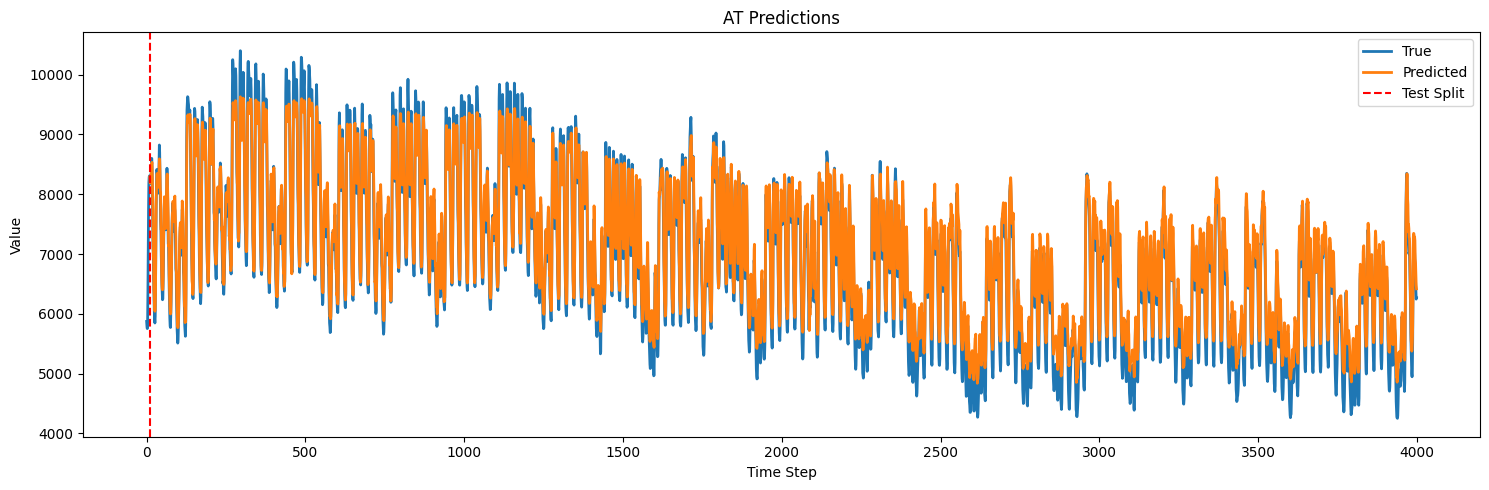

In [65]:
result_tft_test = test_model_per_country(model=model_tft, df=test_df, sequence_length=24, prediction_length=1)
plot_partial_predictions(
    y_true=result_tft_test['AT']['y_true'],
    preds_dict=result_tft_test['AT']['y_pred'],
    split_idx=10,
    group_title="AT Predictions",
    window_size=4000,  # Use the full available length
    start_idx=0
)